In [167]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


In [168]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/mdow/Projects/HCC/Automate_figure_generate/imports.ipynb")

(561, 7)
y    559
n      2
Name: Cancer_census, dtype: int64


### Load data

In [24]:
indir = '/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/'
#mouse = pd.read_pickle(indir + 'mouse_mut_final.pkl')
mouse_fname = '/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/annotated_final_filtered_01162018.csv'
mouse = pd.read_csv(mouse_fname,index_col=0)
mouse['Species'] = 'Mouse'
human = pd.read_pickle(indir + 'human_mut_final.pkl')
print mouse.shape, human.shape

#unstackDf = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/mutation_score_table_combo.pkl')
#mouse_mutScore = unstackDf[~unstackDf.index.str.contains('DO')]
#print unstackDf.shape, mouse_mutScore.shape
mouse_mutScore = pd.read_pickle('mouse_mutation_score.pkl')
human_mutScore = pd.read_pickle('human_mutation_score.pkl')

#pValDf = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/gene_rank_pVal.pkl')
pValDf = pd.read_pickle('gene_rank_pVal_filtered.pkl')
print pValDf.shape

(82431, 40) (842447, 20)
(14104, 5)


### Processing

In [25]:
subCols = ['MODEL','SAMPLE','SYMBOL','Consequence','Species']

combo = pd.concat([mouse[subCols],human[subCols]])

#combo[combo.Species == 'Human'].groupby('SYMBOL').SAMPLE.nunique()

nonSyn_ls = missense + nonsense + splice + frameshift + inframeIndel
combo['nonSyn'] = combo.Consequence.isin(nonSyn_ls)

'''
Count gene alteration
'''
mask_h = combo.Species == 'Human'
mask_m = combo.Species == 'Mouse'
m1= combo.nonSyn == True

geneCnt_h = combo[(mask_h&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')
geneCnt_m = combo[(mask_m&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')

numH = combo[(mask_h&m1)].SAMPLE.nunique()
numM = combo[(mask_m&m1)].SAMPLE.nunique()
geneCnt_m ['Pct'] =geneCnt_m.Count/float(numM)
geneCnt_h ['Pct'] =geneCnt_h.Count/float(numH)

geneCnt_h.head()

'''
Count total mutations
'''
# For stack plot - need the total (green) and the non-syn (blue)
mutCnt = combo[(mask_m&m1)].groupby(['SAMPLE']).nonSyn.value_counts().reset_index(name='nonSyn_Count')

mutCnt_total= mouse[mouse.Consequence.isin(syn+nonSyn_ls)].groupby('SAMPLE').Uploaded_variation.nunique().reset_index(name='Total')

mutCnt_all = pd.merge(mutCnt,mutCnt_total)

'''
Count total mutations human
'''
# For stack plot - need the total (green) and the non-syn (blue)
mutCnt_h = combo[(mask_h&m1)].groupby(['SAMPLE']).nonSyn.value_counts().reset_index(name='nonSyn_Count')

mutCnt_total_h= human[human.Consequence.isin(syn+nonSyn_ls)].groupby('SAMPLE').Uploaded_variation.nunique().reset_index(name='Total')

mutCnt_all_h = pd.merge(mutCnt_h,mutCnt_total_h)

### Set myGenes !!!

In [26]:
tcga_genes = pd.read_csv('tcga_hcc_genes.txt',header=None)
icgc_genes = pd.read_csv('icgc_hcc_genes.txt',header=None)
tcga_genes.columns = ['Gene']
icgc_genes.columns = ['Gene']

hcc_genes = tcga_genes.Gene.tolist() + icgc_genes.Gene.tolist()

In [27]:
removeLs = pd.read_pickle('mouse_large_genes.pkl').gene
falseLs = pd.read_pickle('mouse_lowGenes.pkl').Genes
# If interested in the sig genes 
m1=~pValDf.Genes.isin(removeLs)
m2=~pValDf.Genes.isin(falseLs)
p_sub = pValDf[(m1&m2)]
sigLs = get_sigGenes(p_sub, 0.05, 20)
#myGenes = pd.Series(sigLs).unique()

DEN
False    11273
True        23
Name: DEN, dtype: int64
MUP
False    11295
True         1
Name: MUP, dtype: int64
STAM
False    11227
True        69
Name: STAM, dtype: int64
TAK1
False    11290
True         6
Name: TAK1, dtype: int64


In [28]:
sigLs_all = p_sub.Genes[(p_sub < 0.05).any(axis=1)]

In [29]:
myGenes = sigLs

In [62]:
sigLs_all.shape

(98,)

In [71]:
16+3+81

100

In [94]:
'ep300' in falseLs.tolist()

True

In [95]:
'kmt2c' in removeLs.tolist()

True

In [75]:
'nsd1' in sigLs_all.tolist()

True

In [93]:
'ep300' in sigLs_all.tolist()

False

### What are the mutations that appeared in multiple mouse models

In [21]:
'''# Use before germline filtering 
#!!! Need to change back to germline filtered ones for other plots
unstackDf = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/mutation_score_table_combo.pkl')
mouse_mutScore = unstackDf[~unstackDf.index.str.contains('DO')]

multiModel_df = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/multi_model_mut.pkl')
test = multiModel_df.SYMBOL.unique()

pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(test, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,'mouse_multiModel.pdf')'''

"# Use before germline filtering \n#!!! Need to change back to germline filtered ones for other plots\nunstackDf = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/mutation_score_table_combo.pkl')\nmouse_mutScore = unstackDf[~unstackDf.index.str.contains('DO')]\n\nmultiModel_df = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/multi_model_mut.pkl')\ntest = multiModel_df.SYMBOL.unique()\n\npValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(test, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)\n\ngeneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')\n\nmySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)\n\nplot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,'mouse_multiModel.pdf')"

In [32]:
test = hcc_genes + ['SMARCA4','SF3B1','RB1']

51
Sub pval table: (14104, 5) (41, 5)
Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (56, 41)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:65: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/st

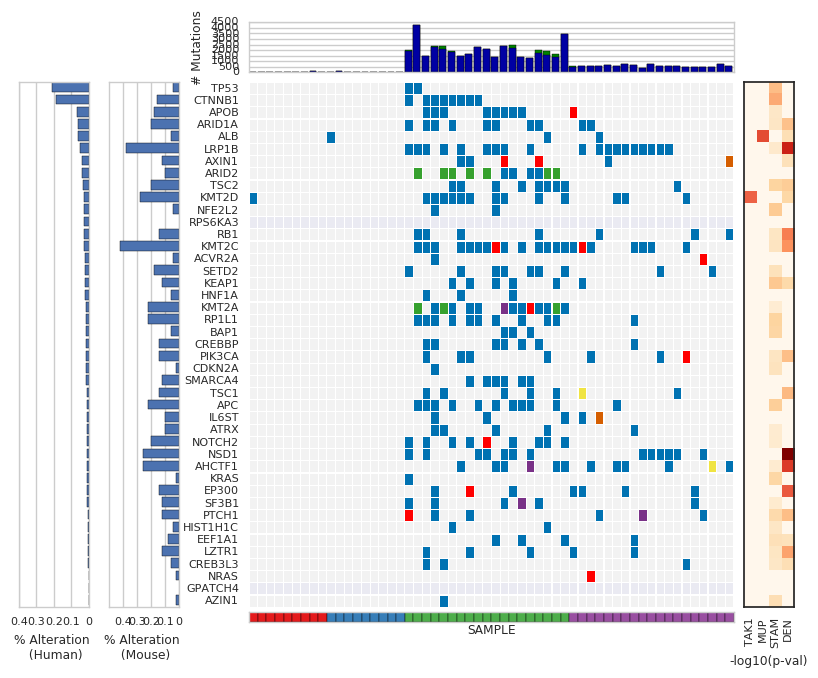

In [33]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(test, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,'mouse_filtered_hcc_more.pdf')

## Final list of genes

In [169]:
human_genes = ['TP53', 'CTNNB1', 'AXIN1', 'ALB', 'BAP1', 'EEF1A1', 'NFE2L2', 'RPS6KA3', 'CDKN2A', 'RB1',
               'ACVR2A', 'KEAP1', 'ARID1A', 'APOB', 'LRP1B', 'ATM', 'TSC2', 'KMT2D', 'SETD2', 'PIK3CA', 'ARID2',
               'KMT2A', 'TRRAP', 'IL6ST', 'NCOR1', 'MTOR', 'FLT4', 'KDM6A', 'MSH6', 'HNF1A', 'PTEN']

mouse_genes = ['APC', 'BRAF', 'KMT2C', 'FAT4', 'BRCA2', 'AHCTF1', 'PTEN', 'ZFHX3', 'FAT1',
               'KIT', 'ALK', 'NOTCH2', 'SF3B1', 'KDR', 'SH2B3', 'STK11', 'ARHGAP26', 'HRAS', 'PTPRT', 'ATR']


In [185]:
sample_order = pd.read_pickle('chasm_order.pkl').index

31
Sub pval table: (14104, 5) (31, 5)
Sub count tables in human and mouse: (31, 3) (30, 3)
Sub main table: (56, 30)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'ATM', 'ACVR2A', 'SETD2', 'HNF1A', 'KEAP1', 'KMT2A', 'BAP1', 'PIK3CA', 'CDKN2A', 'FLT4', 'TRRAP', 'MTOR', 'IL6ST', 'NCOR1', 'MSH6', 'KDM6A', 'PTEN', 'EEF1A1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'ATM', 'ACVR2A', 'SETD2', 'HNF1A', 'KEAP1', 'KMT2A', 'BAP1', 'PIK3CA', 'CDKN2A', 'FLT4', 'TRRAP', 'MTOR', 'IL6ST', 'NCOR1', 'MSH6', 'KDM6A', 'PTEN', 'EEF1A1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:70: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


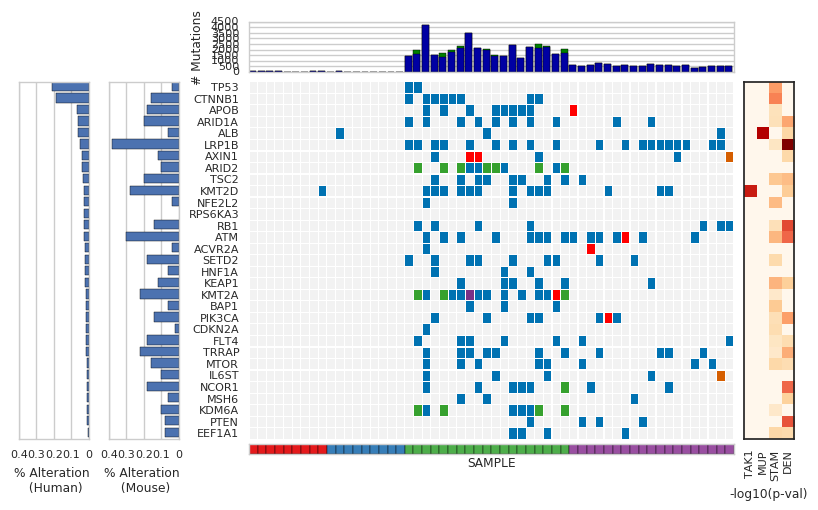

In [193]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(human_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

mutCnt_all_srt = mutCnt_all.set_index(['SAMPLE']).loc[sample_order,:]
mutCnt_all_srt['SAMPLE'] = mutCnt_all_srt.index

plot_final(mySorted.loc[sample_order,:].fillna(0), pValDf_sub_srt, mutCnt_all_srt, geneCnt_h_srt, geneCnt_m_srt,'human_ranked_all.pdf')

20
Sub pval table: (14104, 5) (20, 5)
Sub count tables in human and mouse: (19, 3) (20, 3)
Sub main table: (56, 20)
['FAT4', 'KMT2C', 'BRAF', 'BRCA2', 'ZFHX3', 'FAT1', 'AHCTF1', 'APC', 'NOTCH2', 'PTPRT', 'ATR', 'ALK', 'SH2B3', 'ARHGAP26', 'SF3B1', 'KDR', 'HRAS', 'KIT', 'PTEN', 'STK11']
['FAT4', 'KMT2C', 'BRAF', 'BRCA2', 'ZFHX3', 'FAT1', 'AHCTF1', 'APC', 'NOTCH2', 'PTPRT', 'ATR', 'ALK', 'SH2B3', 'ARHGAP26', 'SF3B1', 'KDR', 'HRAS', 'KIT', 'PTEN', 'STK11']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


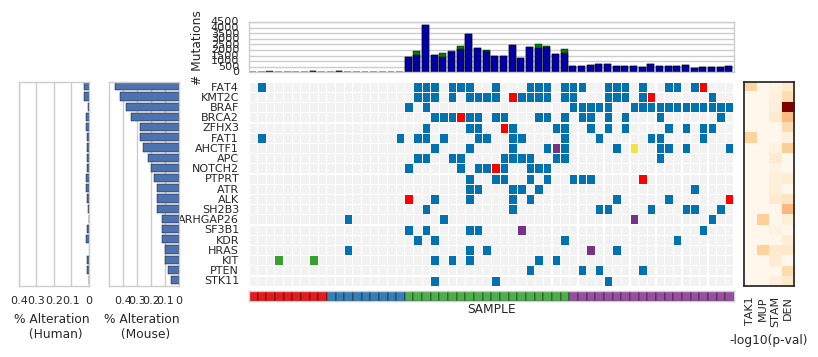

In [191]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(mouse_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)
# Use the same order as last plot
mutCnt_all_srt = mutCnt_all.set_index(['SAMPLE']).loc[sample_order,:]
mutCnt_all_srt['SAMPLE'] = mutCnt_all_srt.index

plot_final(mySorted.loc[sample_order,:], pValDf_sub_srt, mutCnt_all_srt, geneCnt_h_srt, geneCnt_m_srt,'mouse_ranked_all.pdf')

In [192]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


### Start Running

48
Sub pval table: (14104, 5) (41, 5)
Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (56, 41)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:65: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/st

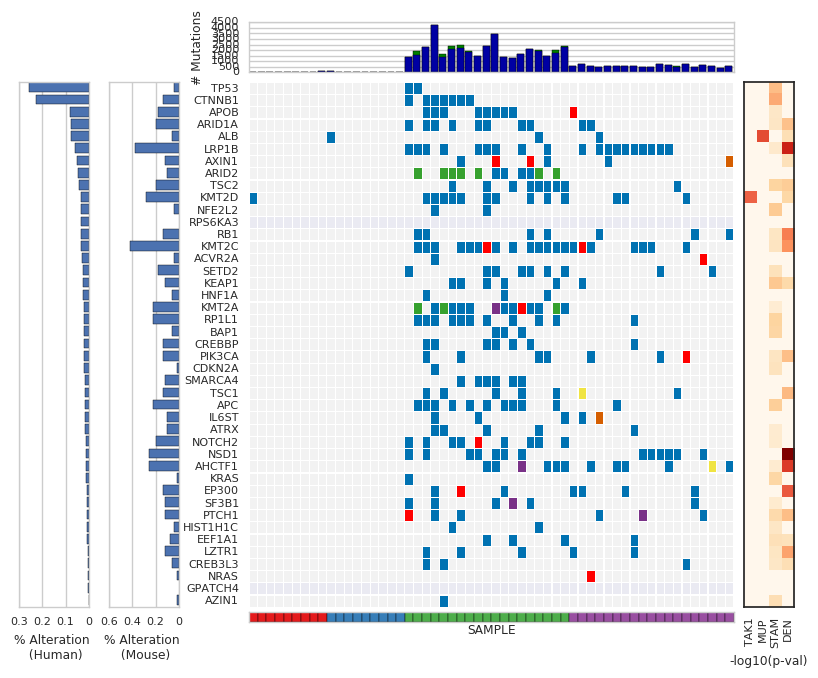

In [696]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(hcc_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)


mutCnt_all_srt = mutCnt_all.set_index(['SAMPLE']).loc[mySorted.index,:]
mutCnt_all_srt['SAMPLE'] = mutCnt_all_srt.index


plot_final(mySorted, pValDf_sub_srt, mutCnt_all_srt, geneCnt_h_srt, geneCnt_m_srt,'mouse_filtered_hcc.pdf')

In [697]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


In [671]:
mySorted.to_pickle('main_heatmap_sorted.pkl')

In [672]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


In [662]:
mainComut_order = mySorted.index

In [663]:
mainComut_order

Index([u'AT863T1', u'AT136T1', u'AT136T2', u'AT136T3', u'AT332', u'AT66T1',
       u'AT66T2', u'AT66T3', u'AT81', u'HFD-13', u'HFD-10', u'HFD1-T1',
       u'HFD1-T2', u'J341-T1', u'J341-T2', u'J406-T2', u'J406-T3', u'J406-T4',
       u'J758_T1_S4', u'J759T4', u'J757_T1_S6', u'J750_T1_S2', u'J759T5',
       u'J756T3', u'J758T3', u'J756T4', u'J756T8', u'J757_T7_S7',
       u'J759_T1_S10', u'J757_T6_S1', u'J758_T4_S', u'J757T3', u'J757_T3_S5',
       u'J750T2', u'J755_T1_S3', u'J759T2', u'J756T1', u'T93', u'T92', u'T7',
       u'T89', u'T38', u'T30', u'T32', u'T67', u'T79', u'T86', u'T42', u'T58',
       u'T19', u'T62', u'T82', u'T34', u'T20', u'T61', u'T71'],
      dtype='object', name=u'SAMPLE')

### mouse significant genes

In [121]:
fp=['wdr11','kdm4d','spag9','ehhadh','krt1','eva1a']
sigLs_sub = sigLs_all[~sigLs_all.isin(fp)]

In [122]:
print ', '.join([g.upper() for g in fp])

WDR11, KDM4D, SPAG9, EHHADH, KRT1, EVA1A


98
Sub pval table: (14104, 5) (98, 5)
Sub count tables in human and mouse: (94, 3) (96, 3)
Sub main table: (56, 96)
['VCAN', 'MUC5B', 'MDN1', 'BRAF', 'DNAH10', 'BRCA2', 'MUC5AC', 'ATM', 'STAB1', 'ATP1A3', 'DUOX1', 'NSD1', 'TRANK1', 'DNMT1', 'ARHGAP31', 'XIRP2', 'IQGAP1', 'IGSF9B', 'FASN', 'MROH2B', 'ZNF831', 'RP1', 'WDR11', 'NFX1', 'FBXO41', 'ZNF48', 'HNRNPC', 'CLCN1', 'PLIN4', 'TERT', 'NOL8', 'MYH8', 'LONP2', 'ZSWIM8', 'ADAM18', 'CDH15', 'N4BP2', 'UFSP2', 'RECQL4', 'SLC5A1', 'SMARCAL1', 'SSFA2', 'CTNNB1', 'PILRA', 'NUTM1', 'DDX21', 'CASKIN1', 'TRMT13', 'SH2B3', 'ABL1', 'AOC1', 'ATP11B', 'GAPVD1', 'KDM4D', 'WDR31', 'WDR90', 'BCL9L', 'ARHGAP29', 'MBIP', 'ZNF205', 'ZNF703', 'TARBP1', 'SPAG9', 'CASP1', 'TFAP2C', 'REPS1', 'ABCB10', 'KIAA0319', 'RASIP1', 'PRR12', 'METAP2', 'PHF1', 'MTBP', 'NLRC5', 'ESR2', 'ITGB4', 'RUVBL1', 'ULK2', 'KIAA2022', 'ZBTB22', 'GCC1', 'MICALL1', 'FHL1', 'TUBB1', 'U2AF2', 'PELP1', 'CCDC169-SOHLH2', 'SPICE1', 'PSPC1', 'RAB7A', 'SLC2A3', 'ITGA7', 'EHHADH', 'KRT1', 'E

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


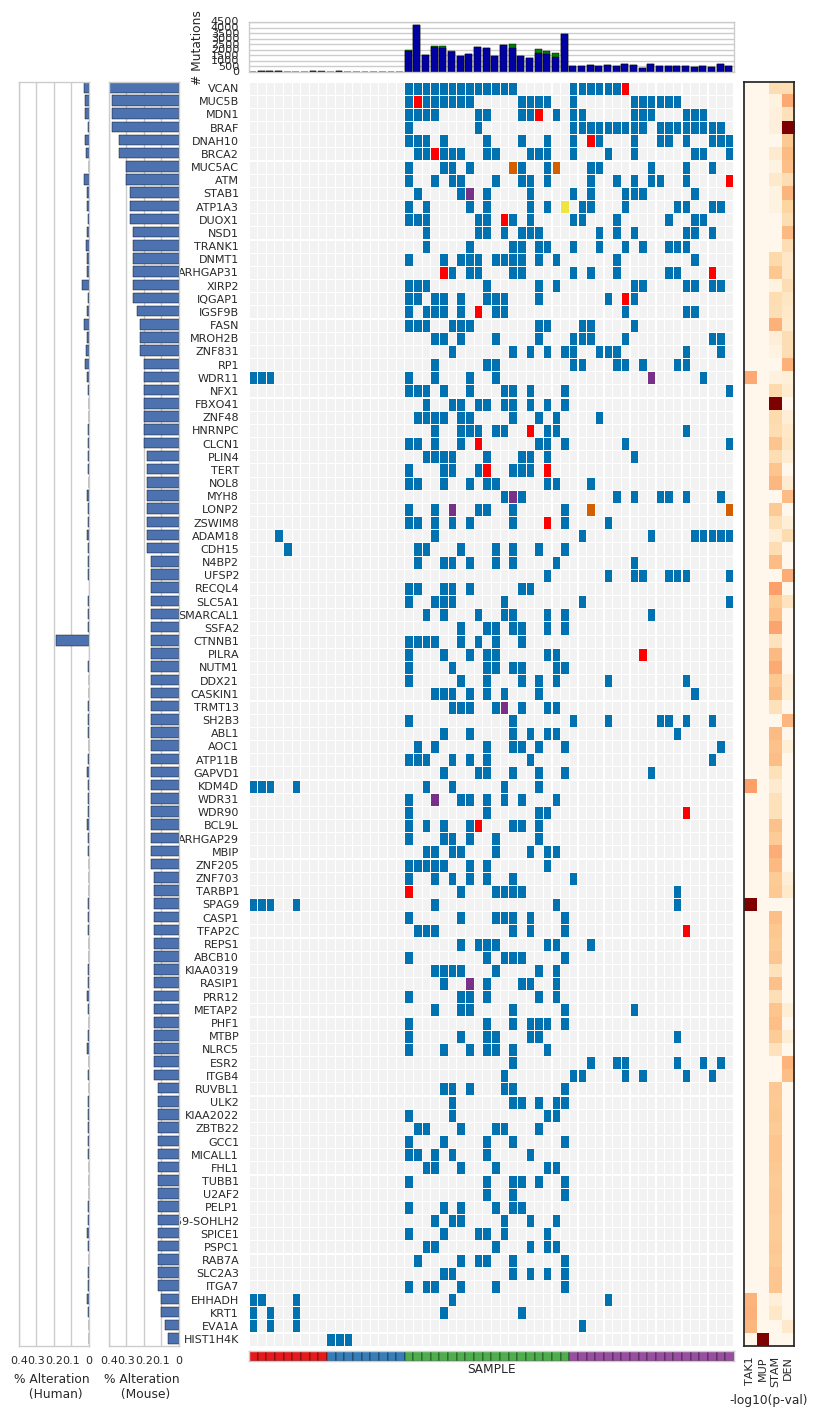

In [150]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigLs_all, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

#plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.pdf')
plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_sig_all.pdf')

In [131]:
tmp = geneCnt_h.copy().set_index(['SYMBOL'])

In [133]:
sigLs_sub_up = [g.upper() for g in sigLs_sub]

In [136]:
geneCnt_h.shape, geneCnt_m.shape

((16502, 3), (13033, 3))

In [ ]:
geneCnt_h.copy().set_index(['SYMBOL'])

In [140]:
geneCnt_m.head()

,SYMBOL,Count,Pct
0,A1BG,5,0.089286
1,A1CF,3,0.053571
2,A2M,7,0.125000
3,A3GALT2,3,0.053571
4,A4GNT,3,0.053571


92
Sub pval table: (14104, 5) (92, 5)
Sub count tables in human and mouse: (88, 3) (90, 3)
Sub main table: (56, 90)
['VCAN', 'MUC5B', 'BRAF', 'MDN1', 'BRCA2', 'DNAH10', 'ATM', 'MUC5AC', 'STAB1', 'DUOX1', 'ATP1A3', 'DNMT1', 'NSD1', 'IQGAP1', 'TRANK1', 'ARHGAP31', 'XIRP2', 'IGSF9B', 'MROH2B', 'FASN', 'ZNF831', 'HNRNPC', 'FBXO41', 'CLCN1', 'NFX1', 'RP1', 'ZNF48', 'NOL8', 'LONP2', 'PLIN4', 'TERT', 'MYH8', 'ZSWIM8', 'ADAM18', 'CDH15', 'TRMT13', 'UFSP2', 'SMARCAL1', 'RECQL4', 'SSFA2', 'CASKIN1', 'PILRA', 'BCL9L', 'NUTM1', 'CTNNB1', 'DDX21', 'SH2B3', 'SLC5A1', 'N4BP2', 'ABL1', 'ATP11B', 'GAPVD1', 'WDR31', 'WDR90', 'ARHGAP29', 'ZNF205', 'AOC1', 'MBIP', 'TFAP2C', 'TARBP1', 'CASP1', 'ZNF703', 'ITGB4', 'REPS1', 'ABCB10', 'KIAA0319', 'RASIP1', 'METAP2', 'PRR12', 'PHF1', 'NLRC5', 'MTBP', 'ESR2', 'FHL1', 'KIAA2022', 'ITGA7', 'ZBTB22', 'MICALL1', 'GCC1', 'RUVBL1', 'ULK2', 'SLC2A3', 'TUBB1', 'PELP1', 'PSPC1', 'RAB7A', 'SPICE1', 'CCDC169-SOHLH2', 'U2AF2', 'HIST1H4K']
['VCAN', 'MUC5B', 'BRAF', 'MDN1', '

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


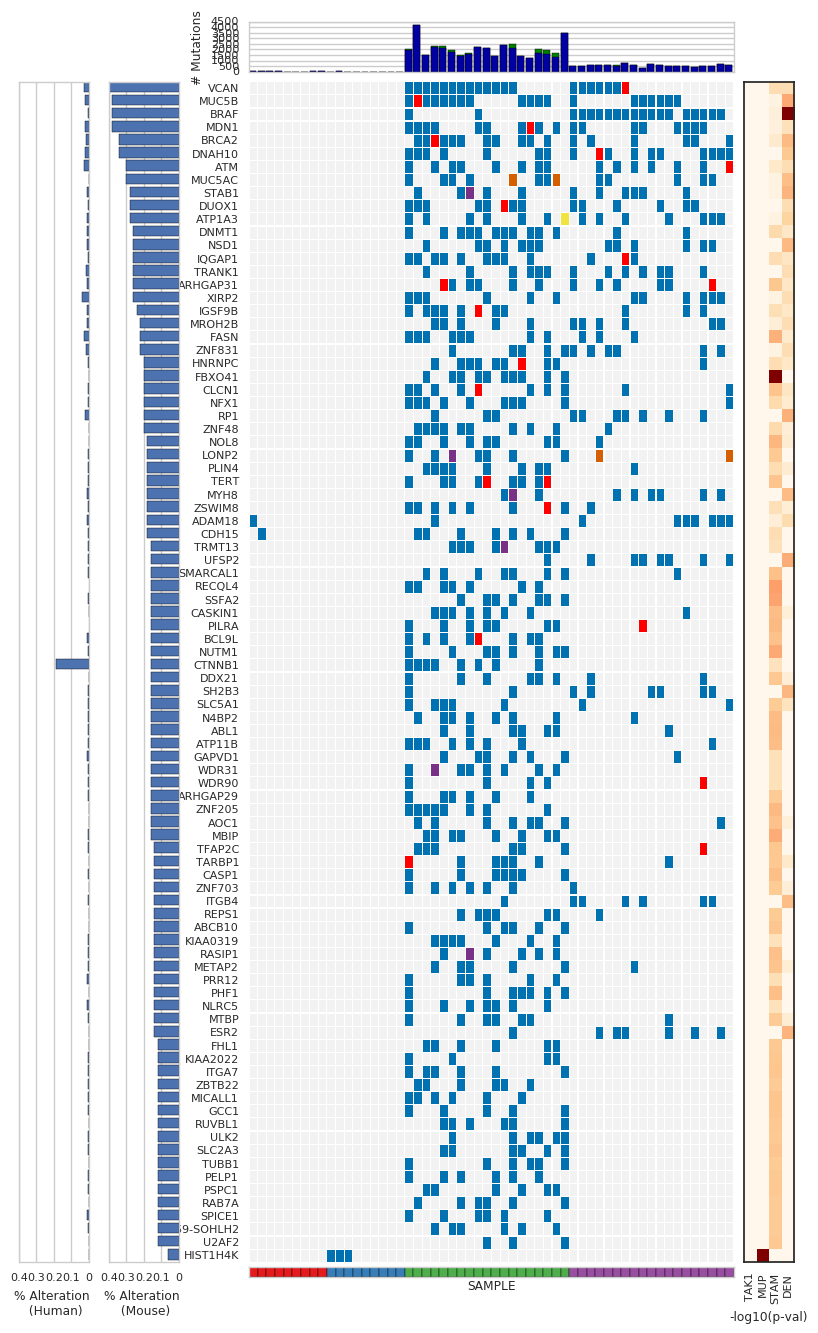

In [152]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigLs_sub, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

#plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.pdf')
plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_sig_filtered2.pdf')

## What happened to some of the previously listed genes?

In [163]:
add_ls = ['ahctf1','kmt2c','kmt2d','ep300','lrp1b','rb1']

6
Sub pval table: (14104, 5) (6, 5)
Sub count tables in human and mouse: (6, 3) (6, 3)
Sub main table: (56, 6)
['KMT2C', 'LRP1B', 'KMT2D', 'AHCTF1', 'EP300', 'RB1']
['KMT2C', 'LRP1B', 'KMT2D', 'AHCTF1', 'EP300', 'RB1']


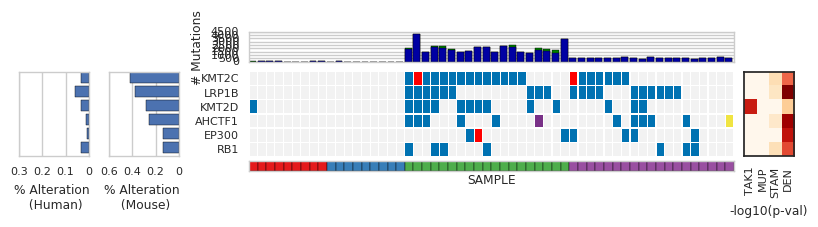

In [164]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(add_ls, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

#plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.pdf')
plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.pdf')

In [165]:
sigLs_sub_2 = sigLs_sub.tolist() + add_ls

98
Sub pval table: (14104, 5) (98, 5)
Sub count tables in human and mouse: (94, 3) (96, 3)
Sub main table: (56, 96)
['KMT2C', 'VCAN', 'LRP1B', 'MDN1', 'MUC5B', 'BRAF', 'BRCA2', 'DNAH10', 'MUC5AC', 'ATM', 'DUOX1', 'STAB1', 'KMT2D', 'ATP1A3', 'NSD1', 'ARHGAP31', 'AHCTF1', 'TRANK1', 'DNMT1', 'XIRP2', 'IQGAP1', 'IGSF9B', 'FASN', 'MROH2B', 'ZNF831', 'CLCN1', 'NFX1', 'FBXO41', 'ZNF48', 'RP1', 'HNRNPC', 'LONP2', 'TERT', 'NOL8', 'PLIN4', 'MYH8', 'ZSWIM8', 'ADAM18', 'CDH15', 'RECQL4', 'N4BP2', 'SLC5A1', 'SMARCAL1', 'SSFA2', 'PILRA', 'CASKIN1', 'NUTM1', 'CTNNB1', 'DDX21', 'BCL9L', 'TRMT13', 'UFSP2', 'ATP11B', 'ABL1', 'WDR31', 'GAPVD1', 'WDR90', 'ARHGAP29', 'ZNF205', 'MBIP', 'AOC1', 'SH2B3', 'REPS1', 'TFAP2C', 'TARBP1', 'CASP1', 'ZNF703', 'ABCB10', 'ESR2', 'NLRC5', 'KIAA0319', 'ITGB4', 'RB1', 'RASIP1', 'MTBP', 'EP300', 'PRR12', 'PHF1', 'METAP2', 'MICALL1', 'CCDC169-SOHLH2', 'FHL1', 'GCC1', 'ITGA7', 'ZBTB22', 'TUBB1', 'ULK2', 'U2AF2', 'RUVBL1', 'PELP1', 'PSPC1', 'RAB7A', 'SPICE1', 'SLC2A3', 'KIAA2

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


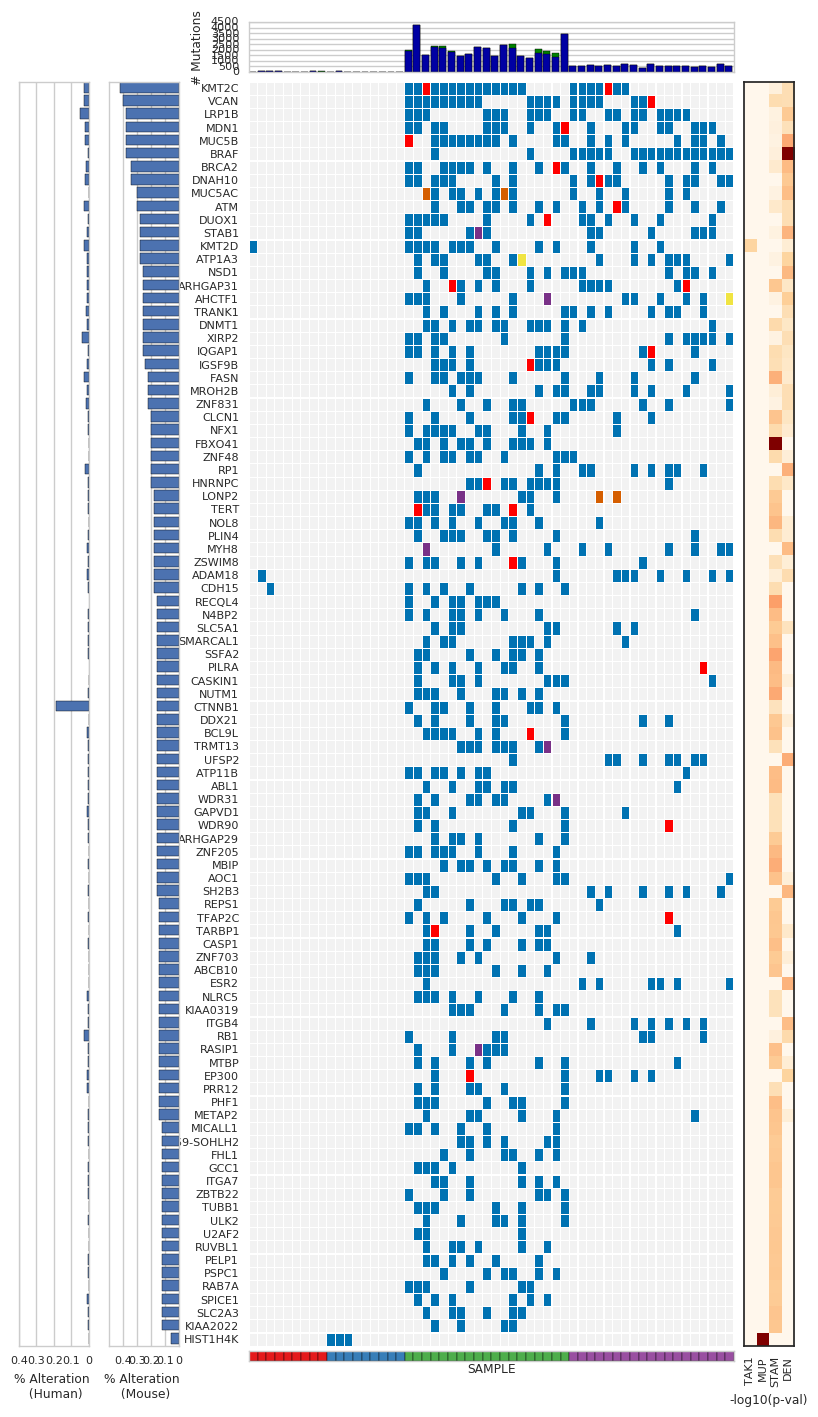

In [166]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigLs_sub_2, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

#plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.pdf')
plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_sig_filtered3.pdf')

In [37]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


In [41]:
hcc_genes_l = [g.lower() for g in hcc_genes]

In [42]:
x = set(sigLs_sub)
y = set(hcc_genes_l)

x.intersection(y)

{'ctnnb1', 'nsd1'}

In [43]:
'alb' in x

False

98
Sub pval table: (14104, 5) (98, 5)
Sub count tables in human and mouse: (94, 3) (96, 3)
Sub main table: (56, 96)
['VCAN', 'MUC5B', 'MDN1', 'BRAF', 'DNAH10', 'BRCA2', 'MUC5AC', 'ATM', 'STAB1', 'ATP1A3', 'DUOX1', 'NSD1', 'TRANK1', 'DNMT1', 'ARHGAP31', 'XIRP2', 'IQGAP1', 'IGSF9B', 'FASN', 'MROH2B', 'ZNF831', 'RP1', 'WDR11', 'NFX1', 'FBXO41', 'ZNF48', 'HNRNPC', 'CLCN1', 'PLIN4', 'TERT', 'NOL8', 'MYH8', 'LONP2', 'ZSWIM8', 'ADAM18', 'CDH15', 'UFSP2', 'ABL1', 'SH2B3', 'SLC5A1', 'SMARCAL1', 'SSFA2', 'PILRA', 'NUTM1', 'DDX21', 'CASKIN1', 'TRMT13', 'N4BP2', 'RECQL4', 'BCL9L', 'ATP11B', 'GAPVD1', 'WDR31', 'WDR90', 'ARHGAP29', 'MBIP', 'ZNF205', 'AOC1', 'KDM4D', 'TFAP2C', 'CASP1', 'TARBP1', 'SPAG9', 'ZNF703', 'REPS1', 'ABCB10', 'ITGB4', 'RASIP1', 'KIAA0319', 'PRR12', 'CTNNB1', 'METAP2', 'PHF1', 'MTBP', 'NLRC5', 'ESR2', 'ULK2', 'KIAA2022', 'ZBTB22', 'GCC1', 'MICALL1', 'FHL1', 'TUBB1', 'U2AF2', 'RUVBL1', 'PELP1', 'CCDC169-SOHLH2', 'SPICE1', 'PSPC1', 'RAB7A', 'SLC2A3', 'ITGA7', 'EHHADH', 'KRT1', 'E

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


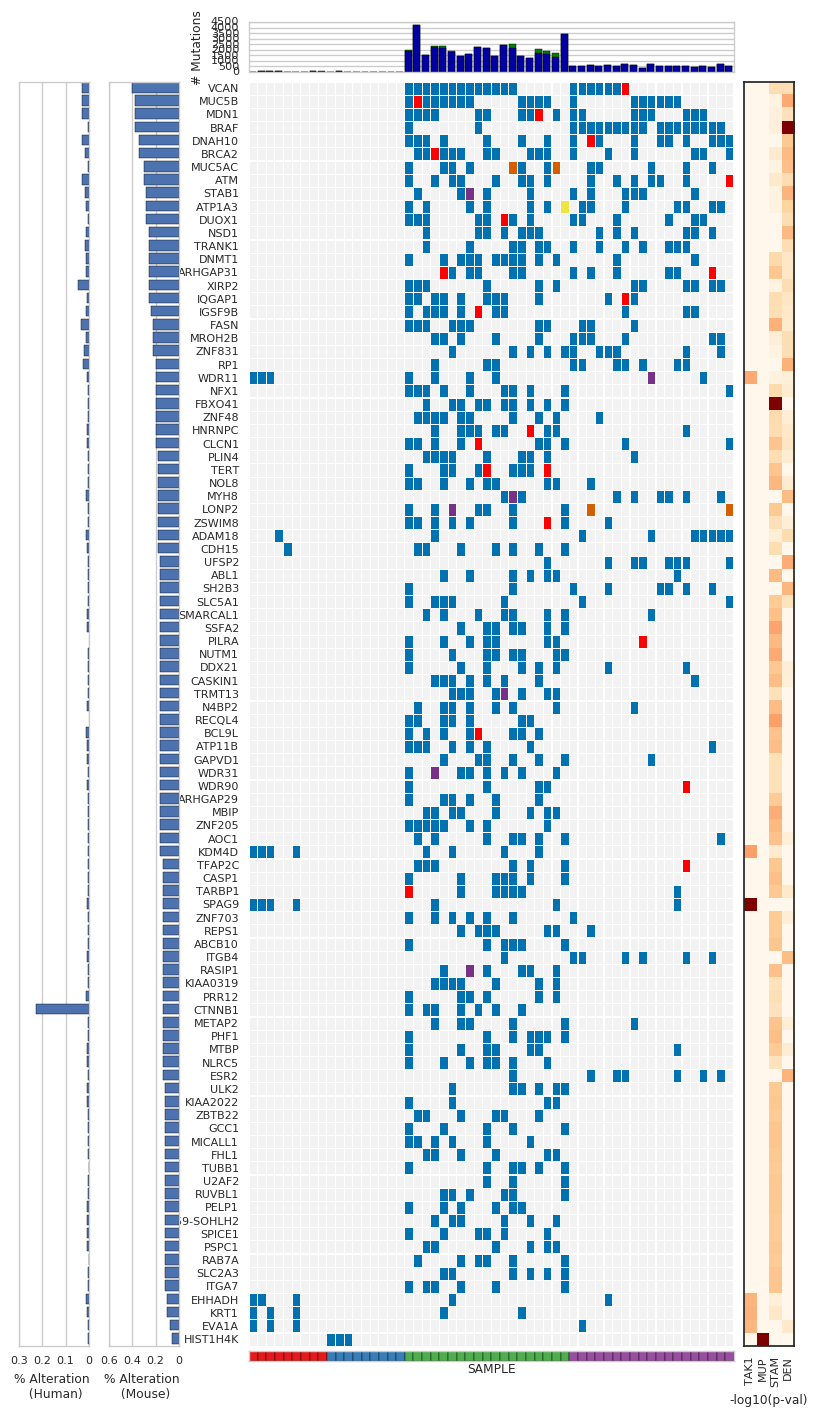

In [259]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigLs_all, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_sig_filtered.pdf')

In [207]:
test = mySorted.index

In [208]:
test = sorted([u'AT136T2', u'AT863T1', u'AT81', u'AT332', u'AT136T3', u'AT136T1',
       u'AT66T3', u'AT66T1', u'AT66T2', u'HFD-10', u'J341-T1', u'HFD1-T2',
       u'J406-T3', u'J341-T2', u'HFD1-T1', u'J406-T2', u'J406-T4', u'HFD-13',
       u'J756T4', u'J758T3', u'J759T2', u'J759T4', u'J759T5', u'J757T3',
       u'J756T3', u'J756T1', u'J755_T1_S3', u'J757_T1_S6', u'J759_T1_S10',
       u'J756T8', u'J757_T7_S7', u'J757_T3_S5', u'J758_T1_S4', u'J757_T6_S1',
       u'J758_T4_S', u'J750_T1_S2', u'J750T2', u'T58', u'T79', u'T71', u'T82',
       u'T7', u'T30', u'T62', u'T93', u'T38', u'T61', u'T19', u'T67', u'T86',
       u'T34', u'T89', u'T42', u'T20', u'T92', u'T32'])

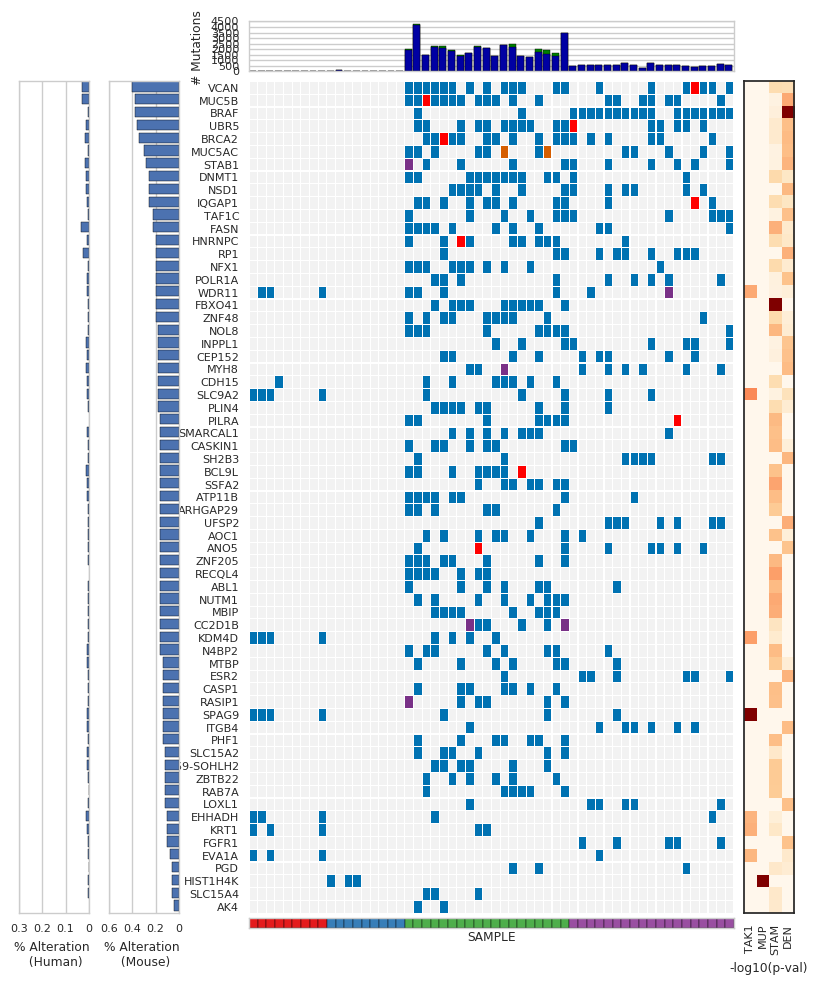

In [117]:
plot_final(mySorted.loc[test,:], pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.pdf')

### Cancer genes

In [197]:
cosmicHGNC.fillna('None').Expert_Curated.value_counts()

None    358
y       199
n         4
Name: Expert_Curated, dtype: int64

In [209]:
new_consensus = pd.read_csv('/cellar/users/mdow/Data/COSMIC/Census_all_01172018.csv').fillna('None')

newCols = [u'Gene', u'Name', u'Entrez', u'Location', u'Tier',
       u'Hallmark', u'Chr Band', u'Somatic', u'Germline',
       u'Tumour Types(Somatic)', u'Tumour Types(Germline)', u'Cancer Syndrome',
       u'Tissue Type', u'Molecular Genetics', u'Role in Cancer',
       u'Mutation Types', u'Translocation Partner', u'Other Germline Mut',
       u'Other Syndrome', u'Synonyms']
new_consensus.columns = newCols

In [210]:
new_consensus.Germline.value_counts()

None    593
yes     106
Name: Germline, dtype: int64

In [222]:
m1=new_consensus.Germline != 'yes'
m2=new_consensus.Somatic == 'yes'
cancerDf= new_consensus[(m1|m2)]
#cancerDf= new_consensus[(m1&m2)]

print new_consensus.shape, cancerDf.shape

cancer_ls = cancerDf.Gene

cancer_lower = [g.lower() for g in cancer_ls.unique()]

(699, 20) (656, 20)


## Mouse significant cancer 

In [225]:
p_cancer = p_sub[p_sub.Genes.isin(cancer_lower)]

cancer_sigGenes = p_cancer[(p_cancer < 0.05).any(axis=1)].Genes

In [231]:
hcc_genes_lower= [g.lower() for g in hcc_genes]

In [235]:
nonHCC_cancer = cancer_sigGenes[~cancer_sigGenes.isin(hcc_genes_lower)]

10
Sub pval table: (14104, 5) (10, 5)
Sub count tables in human and mouse: (10, 3) (10, 3)
Sub main table: (56, 10)
['BRAF', 'BRCA2', 'ATM', 'NSD1', 'TERT', 'ABL1', 'BCL9L', 'NUTM1', 'SH2B3', 'CTNNB1']
['BRAF', 'BRCA2', 'ATM', 'NSD1', 'TERT', 'ABL1', 'BCL9L', 'NUTM1', 'SH2B3', 'CTNNB1']


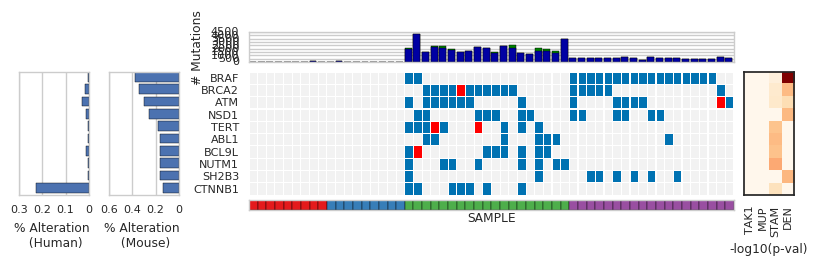

In [688]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(cancer_sigGenes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancerAll_filtered.pdf')

## Resort by main heatmap

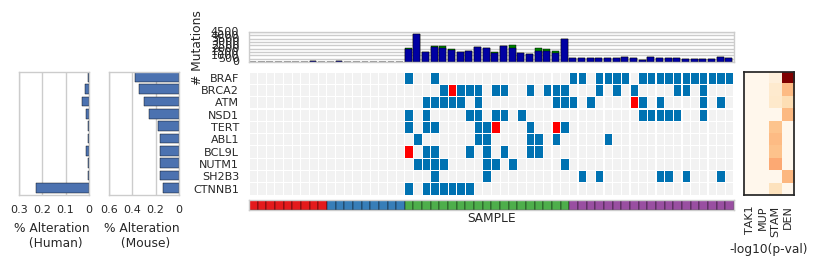

In [692]:
mySorted_re = mySorted.loc[mainComut_order,:]

plot_final_small(mySorted_re, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancerAll_filtered_resort.pdf')

## not HCC cancer genes

8
Sub pval table: (14104, 5) (8, 5)
Sub count tables in human and mouse: (8, 3) (8, 3)
Sub main table: (56, 8)
['BRAF', 'BRCA2', 'ATM', 'TERT', 'ABL1', 'BCL9L', 'NUTM1', 'SH2B3']
['BRAF', 'BRCA2', 'ATM', 'TERT', 'ABL1', 'BCL9L', 'NUTM1', 'SH2B3']


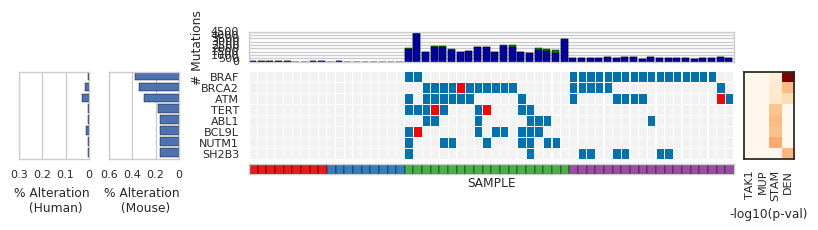

In [665]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(nonHCC_cancer, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancerNotHCC_filtered.pdf')

In [355]:
mySorted.head()

SYMBOL,BRAF,BRCA2,ATM,TERT,ABL1,BCL9L,NUTM1,SH2B3
SAMPLE,,,,,,,,
AT136T1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT136T2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT136T3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT66T1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sort with main order

In [668]:
mySorted_re = mySorted.loc[mainComut_order,:]

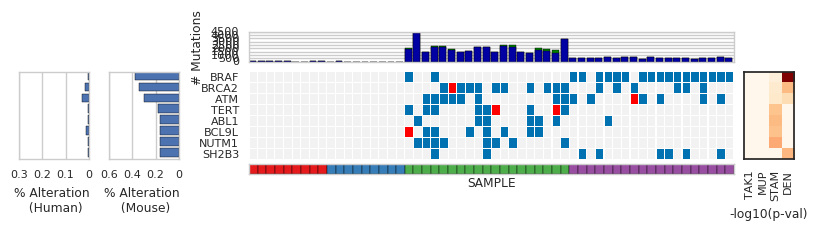

In [669]:
plot_final_small(mySorted_re, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancerNotHCC_filtered_resort.pdf')

## Try human cohorts #!!!

In [283]:
humanToProj_dict = human.set_index(['SAMPLE'])['MODEL'].to_dict()

In [ ]:
'''
sort samples and mutations like coMut waterfall
'''
def sort_comut(mouse_sub_srt, geneCnt_m_srt):
    #1. change to binary
    #2. sort by genes
    mouse_bi = mouse_sub_srt.copy()

    mouse_bi[mouse_bi > 1] = 1

    models = ['TAK1']*9 + ['MUP']*9 + ['STAM']*19 + ['DEN']*19 
    mouse_bi['models'] = models
    mouse_bi = mouse_bi.set_index([mouse_bi.models,mouse_bi.index])

    myGenes = geneCnt_m_srt.index.tolist()
    print myGenes
    mouse_sub_srtS = mouse_bi.sort_values(myGenes,ascending=False).T
    sample_sorted = mouse_sub_srtS.columns.tolist()

    # Get new order sorted by models
    sample_srtDf = pd.DataFrame(sample_sorted)
    sample_srtDf.columns = ['Model','Sample']
    tmp = sample_srtDf.groupby(['Model']).Sample.unique().reset_index()
    newOrder=list()
    for m in ['TAK1','MUP','STAM','DEN']:
        myList = tmp.Sample[tmp.Model == m].tolist()
        for s in myList[0]:
            #print s
            newOrder.append(s)

    mySorted = mouse_sub_srt.reindex(newOrder)
    return mySorted


In [448]:
'''
sort samples and mutations like coMut waterfall
'''
def sort_comut_human(human_sub_srt,geneCnt_h_srt,myDict):
    print 'sort comut'
    #1. change to binary
    #2. sort by genes
    df_bi = human_sub_srt.copy()
    df_bi[df_bi > 1] = 1

    models = pd.Series(human_sub_srt.index).map(myDict)

    myModels = models.unique()
    df_bi['models'] = models.tolist()
    
    df_bi = df_bi.set_index([df_bi.models,df_bi.index])

    myGenes = geneCnt_m_srt.index.tolist()
    #print myGenes
    df_srt = df_bi.sort_values(myGenes,ascending=False).T
    sample_sorted = df_srt.columns.tolist()

    # Get new order sorted by models
    sample_srtDf = pd.DataFrame(sample_sorted)
    sample_srtDf.columns = ['Model','Sample']
    #print sample_srtDf.head()
    tmp = sample_srtDf.groupby(['Model']).Sample.unique().reset_index()
    
    print tmp
    newOrder=list()
    for m in myModels:
        print m
        myList = tmp.Sample[tmp.Model == m].tolist()
        #print myList[0]
        
        for s in myList[0]:
            #print s
            newOrder.append(s)
        print len(newOrder)
    #print df_srt.head()
    #test = human_sub_srt.copy()
    #test.columns = human_sub_srt.index.get_level_values('SAMPLE')
    #print test.head()
    #mySorted = test.loc[:,newOrder]
    mySorted = human_sub_srt.reindex(newOrder)
    return mySorted

In [449]:
geneCnt_h_sub, geneCnt_m_sub, human_sub = subset_dfs_human(hcc_genes, geneCnt_h, geneCnt_m, human_mutScore)
geneCnt_h_srt, geneCnt_m_srt, human_sub_srt = sort_dfs_human(geneCnt_h_sub, geneCnt_m_sub,human_sub,'human')
mySorted = sort_comut_human(human_sub_srt,geneCnt_h_srt,humanToProj_dict)
#plot_final_small_human(mySorted, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_icgc_test.pdf')

Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (835, 43)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
sort comut
     Model                                             Sample
0  LICA-CN  [DO224866, DO224912, DO224597, DO224543, DO224...
1  LICA-FR  [DO50771, DO50902, DO44692, DO50919, DO50928, ...
2  LIHC-US  [DO22848, DO48562, DO52320, DO44938, DO44877, ...
3  LINC-JP  [DO23366, DO23158, DO23270, DO23308, DO23296, ...
LICA-FR
240
LICA-CN
403
LIHC-US
591
LINC-JP
835


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [644]:
def plot_final_small_human(heatmap_df, top_count, left_count_human, left_count_mouse,humanToProj_dict,figname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    numGenes = mySorted.columns.nunique()

    sns.set(font_scale=0.8)
    plt.figure(figsize=(10,numGenes*0.23))
    ax = sns.heatmap(heatmap_df.T,cmap=myCmap,center=0,linewidths=0.1,cbar = 0)

    ax.set_xticklabels('')
    ax.set_ylabel('')

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    sns.set_style('whitegrid')
    axHistx = divider.append_axes("top", size=0.3, pad=0.1, sharex=ax) # Top 
    #sns.set_style('white')
    #axHisty = divider.append_axes("right", size=0.5, pad=0.1) #Right 
    sns.set_style('whitegrid')
    axHistz = divider.append_axes("bottom", size=0.1, pad=0.05, sharex=ax) # Bottom
    axHistk = divider.append_axes("left", size=0.7, pad=0.7, sharey=ax) # Left 1
    axHistk2 = divider.append_axes("left", size=0.7, pad=0.2, sharey=ax) # Left 2
    # the scatter plot:
    # histograms
    lim = 10
    binwidth=2
    bins = np.arange(-lim, lim + binwidth, binwidth)

    # Plot 2 - Top, Stack plot
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.Total, color = "green")
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.nonSyn_Count, color = "#0000A3")

    axHistx.xaxis.set_visible(False)
    axHistx.set_ylabel("# Mutations")


    # Plot 3 - plot on bottom, sample label

    # generate new cohort colors 
    colors = sns.color_palette("Set2", 4)
    proj_to_colors = {'LICA-CN':colors[0],'LICA-FR':colors[1],'LIHC-US':colors[2],'LINC-JP':colors[3]}
    top_count_srt = top_count.set_index(['SAMPLE'])
    top_count_srt = top_count_srt.loc[heatmap_df.index,:]
    cohortColors = pd.Series(top_count_srt.index).map(humanToProj_dict).map(proj_to_colors)
    
    axHistz.bar(xrange(top_count.SAMPLE.nunique()),[1]*top_count.SAMPLE.nunique(), color = cohortColors,width=1)
    axHistz.xaxis.set_visible(False)
    axHistz.yaxis.set_visible(False)

    # Plot 4 - total alterations (Mouse)
    axHistk.barh(xrange(numGenes),left_count_mouse.Count_r)
    axHistk.yaxis.set_visible(False)
    #xCntTicks = [25, 20,15,10,5,0]
    xCntTicks = [-30, -20,-10,-0]
    xCntTicksLabel = [0.6,0.4,0.2,0]
    #xTicks = [float("{0:.2f}".format(i/float(56))) for i in xCntTicks]
    axHistk.set_xticks(xCntTicks)
    axHistk.set_xticklabels(xCntTicksLabel)
    axHistk.set_xlabel("% Alteration \n (Mouse)")
    
    # Plot 5 - total alterations (Human)
    axHistk2.barh(xrange(numGenes),left_count_human.Count_r)
    axHistk2.yaxis.set_visible(False)
    axHistk2.set_xticks([-300,-200,-100,0])
    axHistk2.set_xticklabels([0.3,0.2,0.1,0])
    axHistk2.set_xlabel("% Alteration \n (Human)")
    
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    
    ax.figure.savefig(figname, transparent=True)

## Try with subset of genes and subset of patients with mutations

In [589]:
sub_genes = ['ALB', 'APOB', 'ARID1A', 'ARID2', 'AXIN1', 'CTNNB1', 'KMT2D', 'LRP1B', 'TP53', 'TSC2']

geneCnt_h_sub, geneCnt_m_sub, human_sub = subset_dfs_human(sub_genes, geneCnt_h, geneCnt_m, human_mutScore)

human_sum = human_sub.sum(axis=1) > 5
human_noZ = human_sub.loc[human_sum,:]
print human_noZ.shape

geneCnt_h_srt, geneCnt_m_srt, human_sub_srt = sort_dfs_human(geneCnt_h_sub, geneCnt_m_sub,human_noZ,'human')

#!! take the ones that are non-zero 

mySorted = sort_comut_human(human_sub_srt,geneCnt_h_srt,humanToProj_dict)

Sub count tables in human and mouse: (10, 3) (10, 3)
Sub main table: (835, 10)
(188, 10)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D']
sort comut
     Model                                             Sample
0  LICA-CN  [DO224866, DO224912, DO224597, DO224543, DO224...
1  LICA-FR  [DO50771, DO50902, DO44692, DO50919, DO50928, ...
2  LIHC-US  [DO22848, DO48562, DO52320, DO44938, DO44877, ...
3  LINC-JP  [DO23366, DO23158, DO23270, DO23308, DO23296, ...
LICA-CN
25
LICA-FR
83
LIHC-US
116
LINC-JP
188


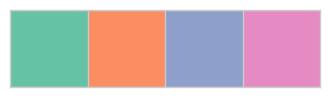

In [652]:
colors = sns.color_palette("Set2", 4)
sns.palplot(colors)

In [635]:
83-25, 116-83, 188-116

(58, 33, 72)

(188, 10) 188


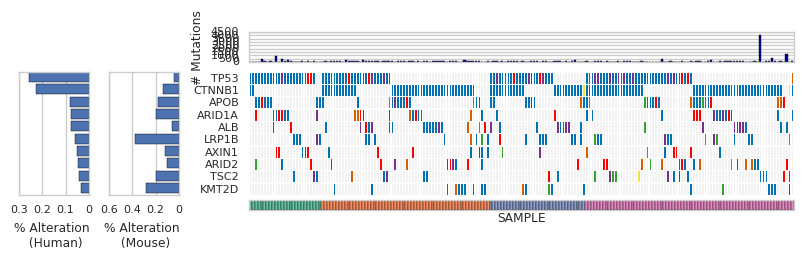

In [646]:
subSams = mySorted.index
print mySorted.shape, len(subSams)
sub_mutCnt_h = mutCnt_all_h[mutCnt_all_h.SAMPLE.isin(subSams)]
plot_final_small_human(mySorted, sub_mutCnt_h, geneCnt_h_srt, geneCnt_m_srt, humanToProj_dict,'human_icgc_hcc_cohorts.pdf')

In [631]:

'''
sort samples and mutations like coMut waterfall
'''
def sort_comut_human_mixed(human_sub_srt,geneCnt_h_srt,myDict):
    print 'sort comut'
    #1. change to binary
    #2. sort by genes
    df_bi = human_sub_srt.copy()
    df_bi[df_bi > 1] = 1

    models = pd.Series(human_sub_srt.index).map(myDict)

    myModels = models.unique()
    df_bi['models'] = models.tolist()
    
    df_bi = df_bi.set_index([df_bi.models,df_bi.index])

    myGenes = geneCnt_m_srt.index.tolist()
    #print myGenes
    df_srt = df_bi.sort_values(myGenes,ascending=False).T
    sample_sorted = df_srt.columns.tolist()

    # Get new order sorted by models
    sample_srtDf = pd.DataFrame(sample_sorted)
    sample_srtDf.columns = ['Model','Sample']
    #print sample_srtDf.head()
    tmp = sample_srtDf.groupby(['Model']).Sample.unique().reset_index()
    
    print tmp
    newOrder=sample_srtDf.Sample.tolist()

    mySorted = human_sub_srt.reindex(newOrder)
    return mySorted

sort comut
     Model                                             Sample
0  LICA-CN  [DO224866, DO224912, DO224597, DO224543, DO224...
1  LICA-FR  [DO50771, DO50902, DO44692, DO50919, DO50928, ...
2  LIHC-US  [DO22848, DO48562, DO52320, DO44938, DO44877, ...
3  LINC-JP  [DO23366, DO23158, DO23270, DO23308, DO23296, ...


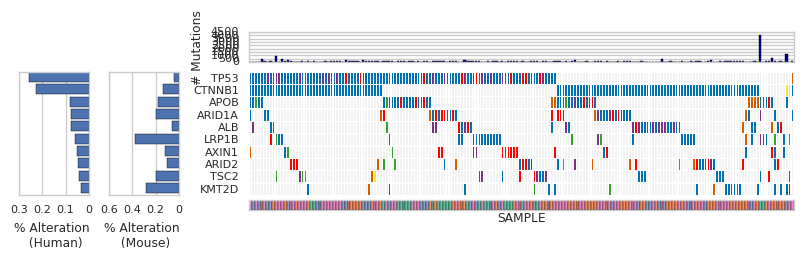

In [647]:
mySorted2 = sort_comut_human_mixed(human_sub_srt,geneCnt_h_srt,humanToProj_dict)
plot_final_small_human(mySorted2, sub_mutCnt_h, geneCnt_h_srt, geneCnt_m_srt, humanToProj_dict,'human_icgc_hcc_mixed.pdf')

## ======

## Previous results

48
Sub pval table: (14107, 5) (41, 5)
Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (56, 41)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:65: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/st

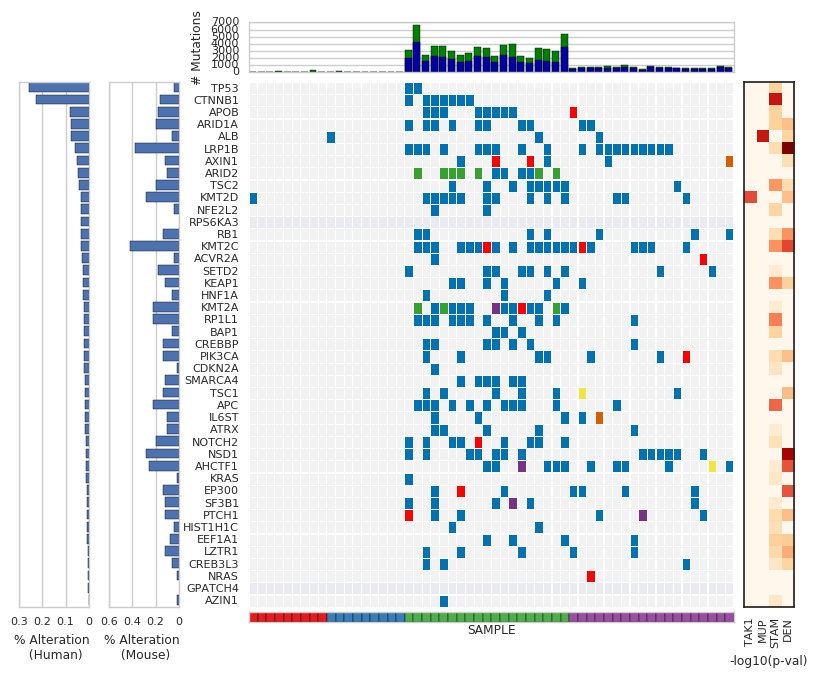

In [48]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(hcc_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,'human_all.pdf')

In [21]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


48
Sub pval table: (14107, 5) (41, 5)
Sub count tables in human and mouse: (43, 3) (41, 3)
Sub main table: (56, 43)
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']
['TP53', 'CTNNB1', 'APOB', 'ARID1A', 'ALB', 'LRP1B', 'AXIN1', 'ARID2', 'TSC2', 'KMT2D', 'NFE2L2', 'RPS6KA3', 'RB1', 'KMT2C', 'ACVR2A', 'SETD2', 'KEAP1', 'HNF1A', 'KMT2A', 'RP1L1', 'BAP1', 'CREBBP', 'PIK3CA', 'CDKN2A', 'SMARCA4', 'TSC1', 'APC', 'IL6ST', 'ATRX', 'NOTCH2', 'NSD1', 'AHCTF1', 'KRAS', 'EP300', 'SF3B1', 'PTCH1', 'HIST1H1C', 'EEF1A1', 'LZTR1', 'CREB3L3', 'NRAS', 'GPATCH4', 'AZIN1']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


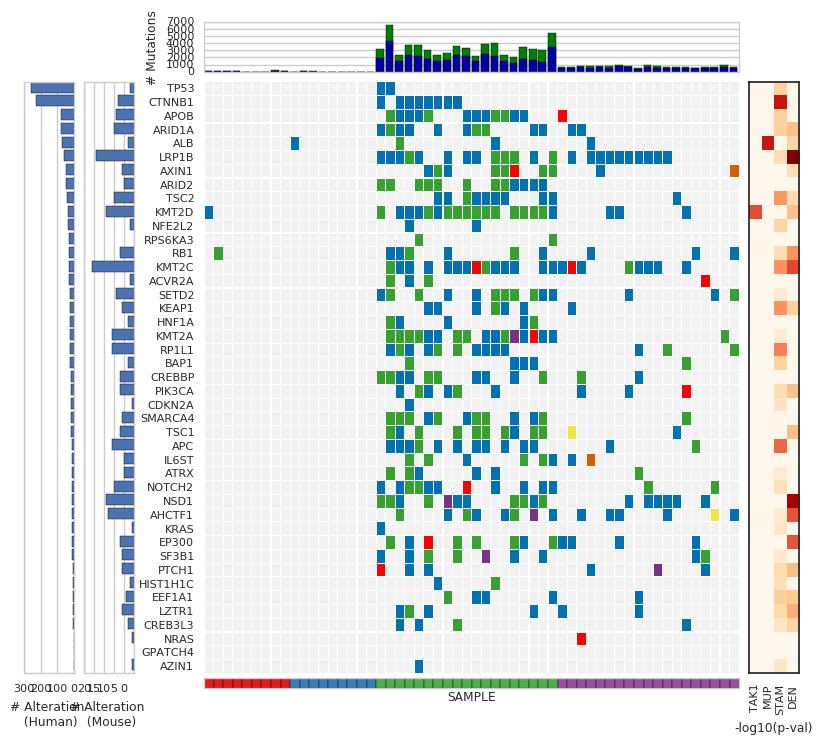

In [54]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(hcc_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'human')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_all.png')

In [55]:
'''
Take out non-recurrent synonymous genes
'''
tcga_genes = ['TP53','CTNNB1','ALB','AXIN1','BAP1','KEAP1','NFE2L2','LZTR1','RB1','PIK3CA',
              'RPS6KA3','AZIN1','KRAS','IL6ST','RP1L1','CDKN2A','EEF1A1','ARID2','ARID1A','GPATCH4',
             'ACVR2A','APOB','CREB3L3','NRAS','AHCTF1','HIST1H1C','SF3B1','SMARCA4']

icgc_genes = ['TP53','LRP1B','KMT2C','ARID1A','AXIN1','ARID2','TSC2','KMT2A','KMT2D','SETD2',
              'CREBBP','RB1','HNF1A','APC','ATRX','EP300','TSC1','NOTCH2','NSD1','PTCH1']

hcc_genes = tcga_genes + icgc_genes
#
# Recurrent if 
# Mutation has appeared in more than 3 sample at the same location

m1 = mouse.SYMBOL.isin(hcc_genes)
m2 = mouse.Consequence == 'synonymous_variant'
syn_hcc = mouse[(m1&m2)]#.Uploaded_variation.value_counts().reset_index()
synCnt = syn_hcc.groupby(['SYMBOL','Uploaded_variation']).SAMPLE.nunique().reset_index()
synCnt.columns = ['SYMBOL','Mutation','Count']

recurSyn = synCnt[synCnt.Count > 2]

recurSyn_genes = recurSyn.SYMBOL.unique()

recurSyn_genes

array(['ACVR2A', 'ARID2', 'KMT2A', 'SETD2', 'TSC1'], dtype=object)

In [56]:
recurSyn

,SYMBOL,Mutation,Count
0,ACVR2A,2_48893557_T/G,3
20,ARID2,15_96289117_C/T,7
22,ARID2,15_96370566_C/T,3
25,ARID2,15_96371886_T/C,3
76,KMT2A,9_44880888_T/G,4
154,SETD2,9_110550250_A/T,3
171,TSC1,2_28665582_C/T,3


In [57]:
tmp = mySorted.copy()
m1 = tmp == 1
m2 = ~tmp.columns.isin(recurSyn_genes)
m3 = tmp.index.str.contains('^J7')
tmp[(m1&m2)] = 0# = 0

In [58]:
# replace non-STAM back? 
tmp.iloc[~m3,:] = mySorted.iloc[~m3,:]

In [59]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


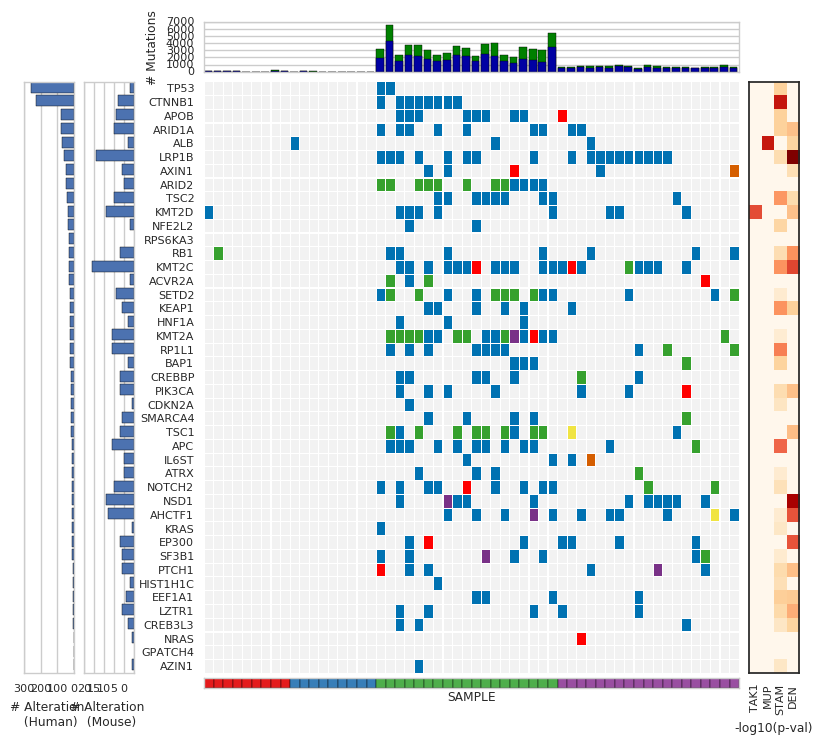

In [61]:
plot_final(tmp, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_recur.pdf')

## Cancer Consensus genes

In [30]:
mouse_sig = pd.read_pickle('/cellar/users/mdow/Projects/HCC/DNA_analysis/Mouse_DNA/Mouse_specific_freqMut_genes.pkl')

myGenes = mouse_sig.columns[~mouse_sig.columns.isin(cosmicHGNC.COSMIC_GENE_NAME)].tolist()

myGenes.remove('OBSCN')
myGenes.remove('VCAN')

In [31]:
print len(myGenes)

49


## Mouse significant genes

49
Sub pval table: (14107, 5) (49, 5)
Sub count tables in human and mouse: (47, 3) (49, 3)
Sub main table: (56, 49)
['MUC5B', 'FCGBP', 'DNAH1', 'DNAH10', 'COL7A1', 'MUC5AC', 'STAB1', 'PLCH1', 'MYH15', 'ATP1A3', 'RBBP6', 'AMBRA1', 'COL4A4', 'TAF1C', 'FASN', 'WDR11', 'ZNF48', 'RP1', 'MYH8', 'ZRANB3', 'FBXO41', 'DNHD1', 'NOL8', 'INPPL1', 'SSFA2', 'UFSP2', 'ZNF205', 'DLG1', 'GUSB', 'MBIP', 'AOC1', 'CASP1', 'PHF1', 'ESR2', 'EEF1D', 'ITGB4', 'RASIP1', 'ZBTB22', 'KHNYN', 'TBC1D15', 'TPH2', 'KRT1', 'RIPK2', 'EHHADH', 'EVA1A', 'FAM160B2', 'PLCXD2', 'HIST1H4K', 'CDCA8']
['MUC5B', 'FCGBP', 'DNAH1', 'DNAH10', 'COL7A1', 'MUC5AC', 'STAB1', 'PLCH1', 'MYH15', 'ATP1A3', 'RBBP6', 'AMBRA1', 'COL4A4', 'TAF1C', 'FASN', 'WDR11', 'ZNF48', 'RP1', 'MYH8', 'ZRANB3', 'FBXO41', 'DNHD1', 'NOL8', 'INPPL1', 'SSFA2', 'UFSP2', 'ZNF205', 'DLG1', 'GUSB', 'MBIP', 'AOC1', 'CASP1', 'PHF1', 'ESR2', 'EEF1D', 'ITGB4', 'RASIP1', 'ZBTB22', 'KHNYN', 'TBC1D15', 'TPH2', 'KRT1', 'RIPK2', 'EHHADH', 'EVA1A', 'FAM160B2', 'PLCXD2', 'HI

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


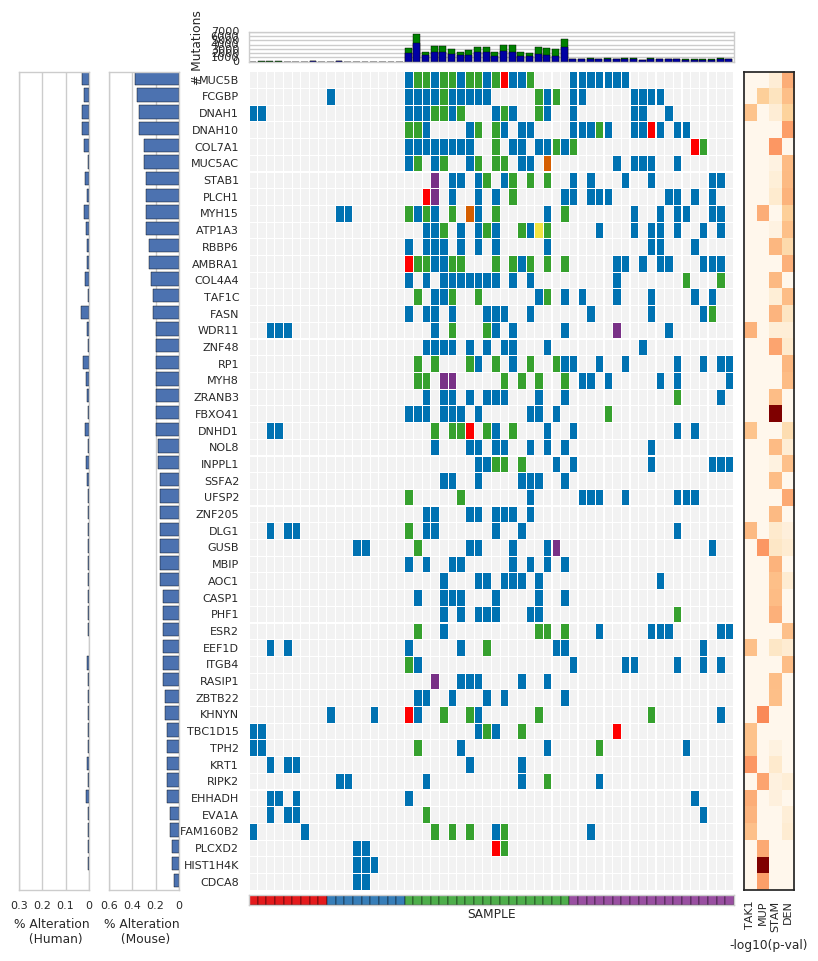

In [80]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(myGenes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_sig.pdf')

## Mouse cancer genes (top 20 significant)

In [33]:
mouse_cancer = mouse_sig.columns[mouse_sig.columns.isin(cosmicHGNC.COSMIC_GENE_NAME)].tolist()

8
Sub pval table: (14107, 5) (8, 5)
Sub count tables in human and mouse: (7, 3) (8, 3)
Sub main table: (56, 8)
['BRAF', 'BRCA2', 'NSD1', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']
['BRAF', 'BRCA2', 'NSD1', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


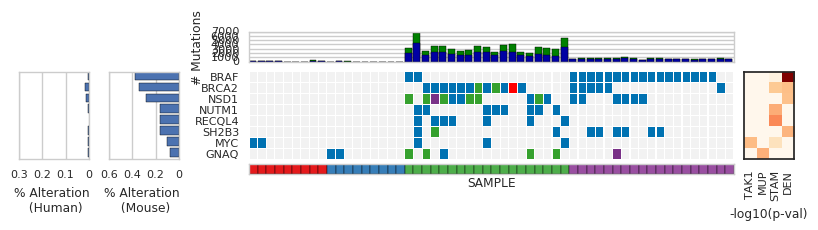

In [34]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(mouse_cancer, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer.pdf')

## Mouse cancer genes (top 20 significant + TERT)

9
Sub pval table: (14107, 5) (9, 5)
Sub count tables in human and mouse: (8, 3) (9, 3)
Sub main table: (56, 9)
['BRAF', 'BRCA2', 'NSD1', 'TERT', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']
['BRAF', 'BRCA2', 'NSD1', 'TERT', 'NUTM1', 'RECQL4', 'SH2B3', 'MYC', 'GNAQ']


/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


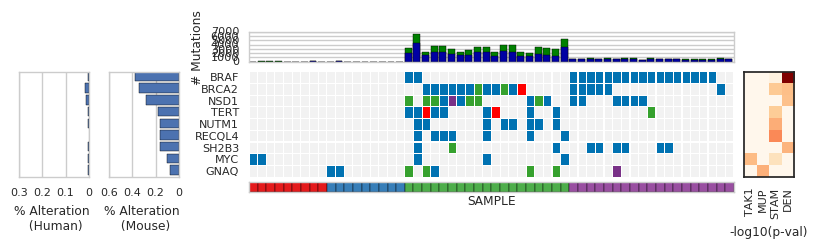

In [114]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(mouse_cancer+ ['TERT'], pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final_small(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer.pdf')

In [115]:
! pwd

/cellar/users/mdow/Projects/HCC/Automate_figure_generate


## Mouse cancer genes (significant in one of the mouse)

In [76]:
cancer_genes = cosmicHGNC.COSMIC_GENE_NAME.tolist()

cancer_genes_l = [g.lower() for g in cancer_genes]

#pValDf.loc['tert',:]

sigGenes_all = pValDf[(pValDf < 0.05).any(axis=1)].Genes
sigGenes_cancer = sigGenes_all[sigGenes_all.isin(cancer_genes_l)]

75
Sub pval table: (14107, 5) (75, 5)
Sub count tables in human and mouse: (72, 3) (75, 3)
Sub main table: (56, 75)
['FAT4', 'KMT2C', 'LRP1B', 'RNF213', 'BRAF', 'UBR5', 'PTPRB', 'BRCA2', 'ATM', 'BCL9', 'KMT2D', 'NSD1', 'FAT1', 'COL1A1', 'ZFHX3', 'FANCD2', 'ARID1B', 'APC', 'PTPRK', 'SUZ12', 'TRRAP', 'SETBP1', 'TSC2', 'SPEN', 'NIN', 'PDGFRB', 'ARHGEF12', 'CNTRL', 'TERT', 'MN1', 'CIITA', 'SH2B3', 'PDGFRA', 'PCM1', 'NUTM1', 'RECQL4', 'NFATC2', 'RET', 'POLE', 'ABL1', 'CBL', 'ASXL1', 'CTNNB1', 'BCL9L', 'CAMTA1', 'BCOR', 'EP300', 'RB1', 'TSHR', 'PAX7', 'ARHGAP26', 'BCL11B', 'HOXA13', 'XPO1', 'KEAP1', 'GATA1', 'TP63', 'STRN', 'SS18L1', 'BUB1B', 'MYC', 'DNM2', 'FGFR1', 'FOXA1', 'OLIG2', 'HRAS', 'LMO2', 'NAB2', 'PTEN', 'PAX8', 'GNAQ', 'CANT1', 'FES', 'NPM1', 'APOBEC3B']
['FAT4', 'KMT2C', 'LRP1B', 'RNF213', 'BRAF', 'UBR5', 'PTPRB', 'BRCA2', 'ATM', 'BCL9', 'KMT2D', 'NSD1', 'FAT1', 'COL1A1', 'ZFHX3', 'FANCD2', 'ARID1B', 'APC', 'PTPRK', 'SUZ12', 'TRRAP', 'SETBP1', 'TSC2', 'SPEN', 'NIN', 'PDGFRB', 'A

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


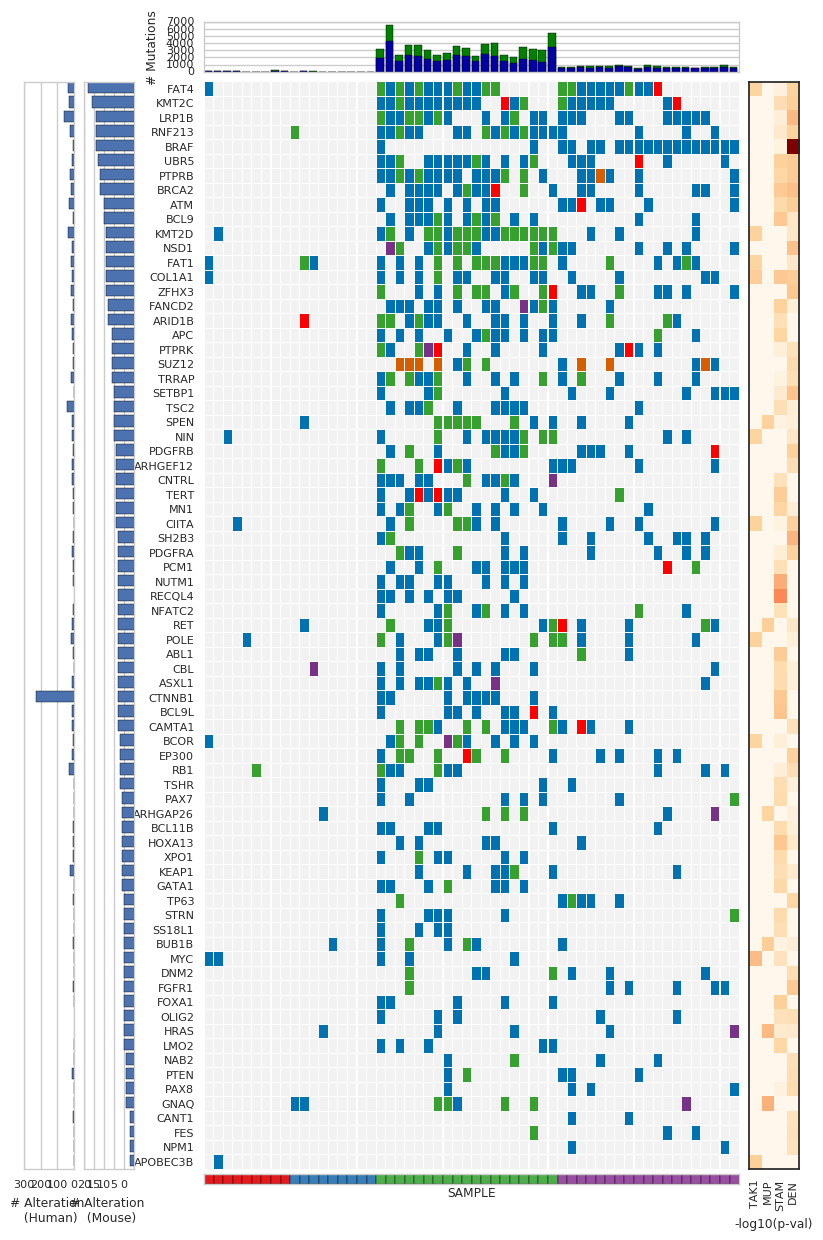

In [108]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigGenes_cancer, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer_sig.pdf')

## Mouse cancer genes (all 500ish)

561
Sub pval table: (14107, 5) (482, 5)
Sub count tables in human and mouse: (514, 3) (460, 3)
Sub main table: (56, 556)
['FAT4', 'KMT2C', 'LRP1B', 'BRAF', 'RNF213', 'UBR5', 'PTPRB', 'BRCA2', 'ATM', 'CACNA1D', 'BCL9', 'FAT1', 'NSD1', 'COL1A1', 'ZFHX3', 'KMT2D', 'FANCD2', 'ARID1B', 'SUZ12', 'APC', 'TRRAP', 'PTPRK', 'KMT2A', 'AFF4', 'CIC', 'SETBP1', 'SPEN', 'TSC2', 'NIN', 'ARID1A', 'NOTCH2', 'PREX2', 'AFF1', 'SETD2', 'PDGFRB', 'FLT4', 'MN1', 'PTPRT', 'CIITA', 'CNTRL', 'TERT', 'TET1', 'COL2A1', 'ARHGEF12', 'NUP214', 'NCOR1', 'ERBB4', 'CTNNB1', 'CHD4', 'ABL1', 'SH2B3', 'NF1', 'PDGFRA', 'PDE4DIP', 'PCM1', 'NUTM1', 'NOTCH1', 'NFATC2', 'NCOR2', 'ROS1', 'NCOA1', 'MTOR', 'PTPN13', 'RECQL4', 'TOP1', 'RET', 'TNFAIP3', 'POLE', 'CBL', 'ALK', 'ASXL1', 'AXIN2', 'BCL9L', 'ATR', 'CARD11', 'CAMTA1', 'CREBBP', 'BCOR', 'MYO5A', 'MYH11', 'FGFR3', 'MUTYH', 'RB1', 'ERBB3', 'MSH2', 'EP300', 'LRIG3', 'MED12', 'DCTN1', 'TET2', 'FANCA', 'TSHR', 'TSC1', 'PML', 'FLT3', 'BLM', 'NUMA1', 'PIK3CA', 'KDM5A', 'BRCA1', '

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


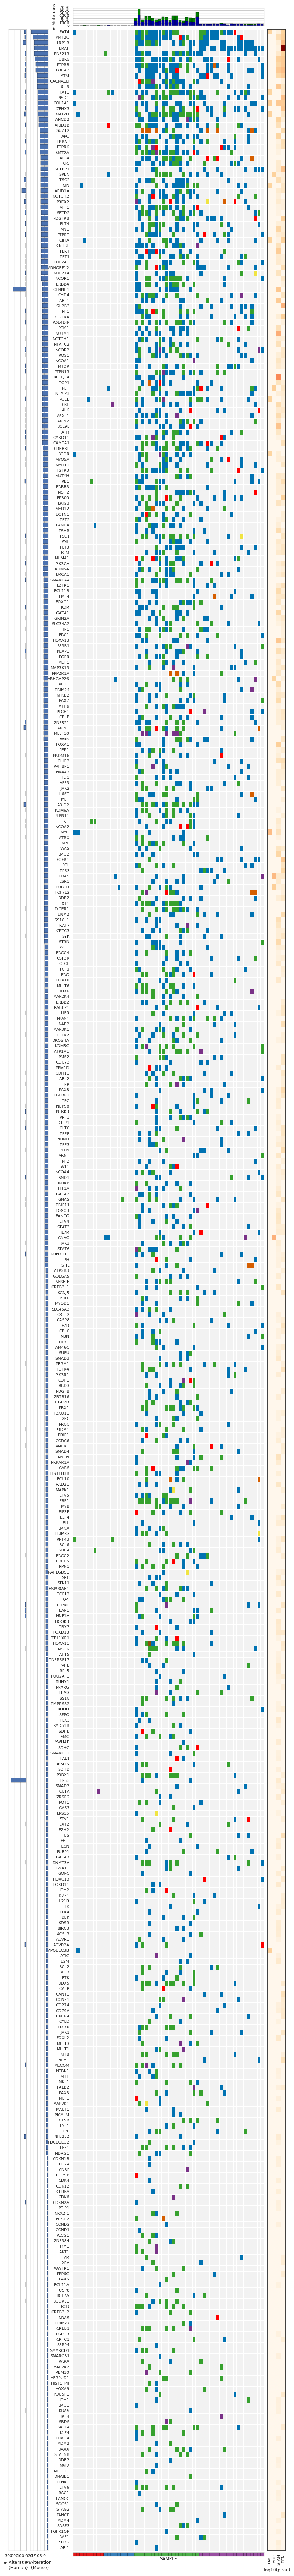

In [107]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(cancer_genes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_cancer_all.pdf')

## scratch

### Plot mouse significantly mutated genes

In [35]:
sigLs = get_sigGenes(pValDf, 0.05, 20)

DEN
False    13401
True       706
Name: DEN, dtype: int64
MUP
False    13951
True       156
Name: MUP, dtype: int64
STAM
False    13401
True       706
Name: STAM, dtype: int64
TAK1
False    13922
True       185
Name: TAK1, dtype: int64


In [36]:
#mouse_sub.iloc[:,mouse_sub.columns == 'HIST1H4K'] 

# TACC2 missense: AT136T1, AT136T2, AT136T3, AT863T1
# MUP HFD-13 is behaving weird, e.g. TMEM199
# MUP HIST1H4K: HFD-10, HFD1-T1, HFD1-T2

80
Sub pval table: (14107, 5) (79, 5)
Sub count tables in human and mouse: (72, 3) (78, 3)
Sub main table: (56, 78)
['HYDIN', 'OBSCN', 'UTRN', 'VCAN', 'LRP1B', 'BRAF', 'MUC5B', 'FCGBP', 'TACC2', 'DNAH10', 'BRCA2', 'PCDH15', 'COL7A1', 'MUC5AC', 'PLCH1', 'MYH15', 'STAB1', 'AMBRA1', 'RBBP6', 'LRBA', 'COL4A4', 'FASN', 'SLC44A5', 'TAF1C', 'RP1', 'FBXO41', 'MYH8', 'WDR11', 'ZNF48', 'ZRANB3', 'SLC9A2', 'NOL8', 'GUSB', 'AOC1', 'UFSP2', 'SSFA2', 'ZNF205', 'SH2B3', 'MBIP', 'RECQL4', 'HDLBP', 'DLG1', 'NUTM1', 'KDM4D', 'RASIP1', 'PHF1', 'CASP1', 'SPAG9', 'ITGB4', 'ZBTB22', 'DPYD', 'KHNYN', 'KRT1', 'WDR55', 'EHHADH', 'MYC', 'HRAS', 'RIPK2', 'PTPA', 'SEMA3A', 'GNAQ', 'EVA1A', 'IRX2', 'HAPLN4', 'NUDT12', 'PGK2', 'ETV2', 'PLCXD2', 'PCYOX1L', 'HIST1H4K', 'ABRA', 'CDCA8', 'TMEM199', 'OR6B1', 'VPS37D', 'TARBP2', 'SNCG', 'KRTDAP']
['HYDIN', 'OBSCN', 'UTRN', 'VCAN', 'LRP1B', 'BRAF', 'MUC5B', 'FCGBP', 'TACC2', 'DNAH10', 'BRCA2', 'PCDH15', 'COL7A1', 'MUC5AC', 'PLCH1', 'MYH15', 'STAB1', 'AMBRA1', 'RBBP6', 'LR

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


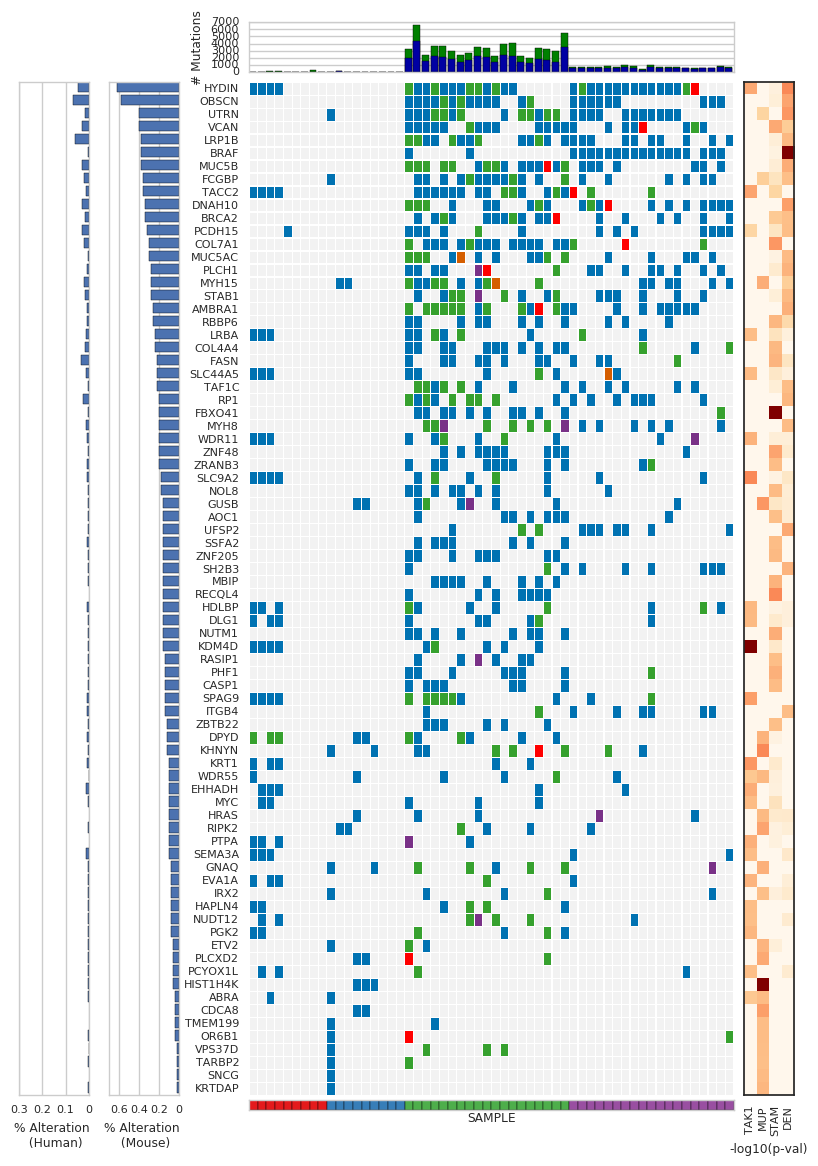

In [37]:
pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(sigLs, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)

geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,'mouse')

mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)

plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'test.png')

In [38]:
#tmp_srt = sort_comut(tmp,geneCnt_m_srt)
#plot_final(tmp_srt, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'mouse_noSyn.png')

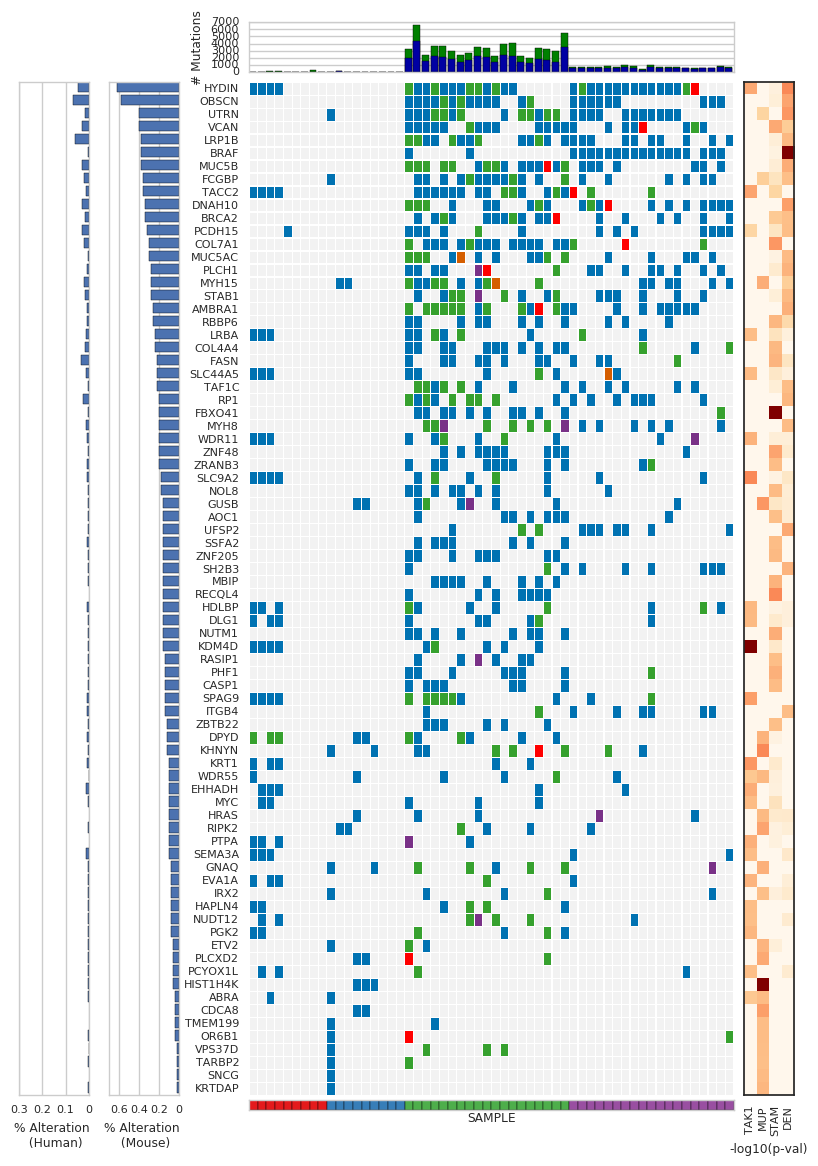

In [39]:
plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt, 'human_all.png')

In [40]:
[i/float(56) for i in [0, 5, 10, 15,20,25]]

[0.0,
 0.08928571428571429,
 0.17857142857142858,
 0.26785714285714285,
 0.35714285714285715,
 0.44642857142857145]

In [41]:
[i/float(891) for i in [0,100,200,300]]

[0.0, 0.1122334455667789, 0.2244668911335578, 0.3367003367003367]

### Chunk

In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from argparse import ArgumentParser


## Functions
def get_sigGenes(pValDf, pThres, topN):
    sigLs = list()
    for i in pValDf.columns[0:4]:
        print i 
        print (pValDf.loc[:,i] < pThres).value_counts()
        sigGenes = pValDf.loc[:,i].sort_values()[0:topN].index
        [sigLs.append(g) for g in sigGenes]
        
    return sigLs

def subset_dfs(myGenes, pValDf, geneCnt_human, geneCnt_mouse, mouse_mutScore):
    myGenes_upper =[g.upper() for g in myGenes]
    myGenes_lower = [g.lower() for g in myGenes]

    # pVal df 
    pValDf_sub = pValDf[pValDf.Genes.isin(myGenes_lower+myGenes_upper)]
    pValDf_sub.index = [g.upper() for g in pValDf_sub.Genes]

    print len(myGenes)
    print 'Sub pval table:', pValDf.shape, pValDf_sub.shape

    # Gene alteration sample count table
    
    geneCnt_h_sub = geneCnt_human[geneCnt_human.SYMBOL.isin(myGenes_lower+myGenes_upper)]
    geneCnt_m_sub = geneCnt_mouse[geneCnt_mouse.SYMBOL.isin(myGenes_lower+myGenes_upper)]
    print 'Sub count tables in human and mouse:', geneCnt_h_sub.shape, geneCnt_m_sub.shape

    # Main score table
    mouse_sub = mouse_mutScore.iloc[:,mouse_mutScore.columns.isin(myGenes_lower+myGenes_upper)]
    print 'Sub main table:',mouse_sub.shape
    
    return pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub


'''
Determine the order of gene
Sorted by gene count, but the table can be either human or mouse
'''
def get_geneOrder(geneCnt):
    # Get gene order from gene counts 
    geneCnt_srt = geneCnt.sort_values('Count',ascending=False)
    geneCnt_srt['Count_r'] =geneCnt_srt.Count * -1
    geneOrder = geneCnt_srt.SYMBOL.tolist()
    
    return geneOrder

def sort_dfs(geneCnt_human, geneCnt_mouse,mouse_sub,pValDf_sub,species):
    
    if species == 'human':
        geneOrder = get_geneOrder(geneCnt_human)
    else:
        geneOrder = get_geneOrder(geneCnt_mouse)
    print geneOrder
    
    # Sort human gene count
    geneCnt_human.index = geneCnt_human.SYMBOL
    geneCnt_h_srt = geneCnt_human.loc[geneOrder,:]
    geneCnt_h_srt['Count_r'] =geneCnt_h_srt.Count * -1
    
    # Sort mouse gene count
    geneCnt_mouse.index = geneCnt_mouse.SYMBOL
    geneCnt_m_srt = geneCnt_mouse.loc[geneOrder,:]
    geneCnt_m_srt['Count_r'] =geneCnt_m_srt.Count * -1

    # Sort the heatmap by this gene list 
    mouse_sub_srt = mouse_sub.loc[:,geneOrder]

    '''
    Mouse model order
    '''
    
    # Sort p-value table
    pValDf_sub_srt = pValDf_sub.loc[geneOrder,model_order].fillna(1)
    
    return geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt


'''
sort samples and mutations like coMut waterfall
'''
def sort_comut(mouse_sub_srt, geneCnt_m_srt):
    #1. change to binary
    #2. sort by genes
    mouse_bi = mouse_sub_srt.copy()

    mouse_bi[mouse_bi > 1] = 1

    models = ['TAK1']*9 + ['MUP']*9 + ['STAM']*19 + ['DEN']*19 
    mouse_bi['models'] = models
    mouse_bi = mouse_bi.set_index([mouse_bi.models,mouse_bi.index])

    myGenes = geneCnt_m_srt.index.tolist()
    print myGenes
    mouse_sub_srtS = mouse_bi.sort_values(myGenes,ascending=False).T
    sample_sorted = mouse_sub_srtS.columns.tolist()

    # Get new order sorted by models
    sample_srtDf = pd.DataFrame(sample_sorted)
    sample_srtDf.columns = ['Model','Sample']
    tmp = sample_srtDf.groupby(['Model']).Sample.unique().reset_index()
    newOrder=list()
    for m in ['TAK1','MUP','STAM','DEN']:
        myList = tmp.Sample[tmp.Model == m].tolist()
        for s in myList[0]:
            #print s
            newOrder.append(s)

    mySorted = mouse_sub_srt.reindex(newOrder)
    return mySorted

def plot_final(heatmap_df, pval_df, top_count, left_count_human, left_count_mouse,figname):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    numGenes = heatmap_df.columns.nunique()

    sns.set(font_scale=0.8)
    plt.figure(figsize=(10,numGenes*0.2))
    ax = sns.heatmap(heatmap_df.T,cmap=myCmap,center=0,linewidths=0.1,cbar = 0)

    ax.set_xticklabels('')
    ax.set_ylabel('')

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    sns.set_style('whitegrid')
    axHistx = divider.append_axes("top", size=0.5, pad=0.1, sharex=ax) # Top 
    sns.set_style('white')
    axHisty = divider.append_axes("right", size=0.5, pad=0.1) #Right 
    sns.set_style('whitegrid')
    axHistz = divider.append_axes("bottom", size=0.1, pad=0.05, sharex=ax) # Bottom
    axHistk = divider.append_axes("left", size=0.5, pad=0.7, sharey=ax) # Left 1
    axHistk2 = divider.append_axes("left", size=0.5, pad=0.1, sharey=ax) # Left 2
    # the scatter plot:
    # histograms
    lim = 10
    binwidth=2
    bins = np.arange(-lim, lim + binwidth, binwidth)


    # Plot 1 - Right, total alterations -> P-value
    sns.set_style('white')
    myPvals_srt = pval_df
    axHisty.imshow(-np.log10(pval_df), cmap='OrRd', interpolation='nearest', aspect='auto')
    axHisty.yaxis.set_visible(False)
    axHisty.set_xticks([0,1,2,3])
    axHisty.set_xlabel("-log10(p-val)")
    axHisty.set_xticklabels(model_order,rotation=90)


    # Plot 2 - Top, Stack plot
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.Total, color = "green")
    axHistx.bar(xrange(top_count.SAMPLE.nunique()),top_count.nonSyn_Count, color = "#0000A3")

    axHistx.xaxis.set_visible(False)
    axHistx.set_ylabel("# Mutations")

    # Plot 3 - plot on bottom, sample label
    axHistz.bar(xrange(top_count.SAMPLE.nunique()),[1]*top_count.SAMPLE.nunique(), color = modelColors,width=1)
    axHistz.xaxis.set_visible(False)
    axHistz.yaxis.set_visible(False)

    # Plot 4 - total alterations (Mouse)
    axHistk.barh(xrange(numGenes),left_count_mouse.Count_r)
    axHistk.yaxis.set_visible(False)
    xCntTicks = [20,15,10,5,0]
    xTicks = [float("{0:.2f}".format(i/float(56))) for i in xCntTicks]
    axHistk.set_xticklabels(xCntTicks)
    axHistk.set_xlabel("# Alteration \n (Mouse)")
    
    # Plot 5 - total alterations (Human)
    axHistk2.barh(xrange(numGenes),left_count_human.Count_r)
    axHistk2.yaxis.set_visible(False)
    axHistk2.set_xticks([-300,-200,-100,0])
    axHistk2.set_xticklabels([300,200,100,0])
    axHistk2.set_xlabel("# Alteration \n (Human)")
    
    ax.figure.savefig(figname)

'''
Load the variant effect definitions 
'''

import var_def

syn = var_def.syn
missense = var_def.missense
splice = var_def.splice
nonsense = var_def.nonsense
frameshift = var_def.frameshift
inframeIndel = var_def.inframeIndel
silentRegions = var_def.silentRegions
others = var_def.others

'''
Model colours
'''
colors = sns.color_palette("Set1", 4)
modelColors=((colors[0],) * 9 +(colors[1],) * 9 + (colors[2],) * 19 +(colors[3],) * 19)

'''
coMut plot colors
'''
brown=sns.color_palette("BrBG", 10)[0]
purple=sns.color_palette("PRGn", 8)[0]
colorLs=sns.color_palette("colorblind", 8)
#blue=sns.color_palette("deep", 10)[0]
blue=sns.color_palette("colorblind", 10)[0]
green = sns.color_palette("Paired", 10)[3]
orange=colorLs[2]
yellow=colorLs[4]

myCmap = mpl.colors.ListedColormap([brown,"#f2f2f2",yellow,orange,"#f2f2f2",green,purple,'r',blue])
model_order = ['TAK1','MUP','STAM','DEN']


def main(geneSet,sortSpecies,figname):

	'''
	Load data
	'''
	mouse = pd.read_pickle('mouse_mut_final.pkl')
	human = pd.read_pickle('human_mut_final.pkl')
	print mouse.shape, human.shape

	unstackDf = pd.read_pickle('mutation_score_table_combo.pkl')
	mouse_mutScore = unstackDf[~unstackDf.index.str.contains('DO')]
	print unstackDf.shape, mouse_mutScore.shape

	pValDf = pd.read_pickle('gene_rank_pVal.pkl')
	print pValDf.shape

	'''
	Load gene set
	'''
	tmp = pd.read_csv(geneSet,header=None)
	tmp.columns = ['Gene']
	myGenes = tmp.Gene.tolist()

	'''
	Process
	'''
	subCols = ['MODEL','SAMPLE','SYMBOL','Consequence','Species']
	combo = pd.concat([mouse[subCols],human[subCols]])
	nonSyn_ls = missense + nonsense + splice + frameshift + inframeIndel
	combo['nonSyn'] = combo.Consequence.isin(nonSyn_ls)

	'''
	Count gene alteration
	'''
	mask_h = combo.Species == 'Human'
	mask_m = combo.Species == 'Mouse'
	m1= combo.nonSyn == True

	geneCnt_h = combo[(mask_h&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')
	geneCnt_m = combo[(mask_m&m1)].groupby(['SYMBOL']).SAMPLE.nunique().reset_index(name='Count')

	numH = combo[(mask_h&m1)].SAMPLE.nunique()
	numM = combo[(mask_m&m1)].SAMPLE.nunique()
	geneCnt_m ['Pct'] =geneCnt_m.Count/float(numM)
	geneCnt_h ['Pct'] =geneCnt_h.Count/float(numH)

	geneCnt_h.head()

	'''
	Count total mutations
	'''
	# For stack plot - need the total (green) and the non-syn (blue)
	mutCnt = combo[(mask_m&m1)].groupby(['SAMPLE']).nonSyn.value_counts().reset_index(name='nonSyn_Count')
	mutCnt_total= mouse[mouse.Consequence.isin(syn+nonSyn_ls)].groupby('SAMPLE').Uploaded_variation.nunique().reset_index(name='Total')
	mutCnt_all = pd.merge(mutCnt,mutCnt_total)

	'''
	Main script
	'''
	pValDf_sub, geneCnt_h_sub, geneCnt_m_sub, mouse_sub = subset_dfs(myGenes, pValDf, geneCnt_h, geneCnt_m, mouse_mutScore)
	geneCnt_h_srt, geneCnt_m_srt, mouse_sub_srt, pValDf_sub_srt = sort_dfs(geneCnt_h_sub, geneCnt_m_sub,mouse_sub,pValDf_sub,sortSpecies)
	mySorted = sort_comut(mouse_sub_srt,geneCnt_m_srt)
	plot_final(mySorted, pValDf_sub_srt, mutCnt_all, geneCnt_h_srt, geneCnt_m_srt,figname)


if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument('--geneSet', dest='geneSet', type=str, default='tcga_hcc_genes.txt', required=False, help='Calculaate correlation by specific gene set') 
    parser.add_argument('--sortSpecies', dest='sortSpecies',type=str, default='mouse', required=False, help='Sort the genes by which species? Type mouse or human')
    parser.add_argument('--figname', dest='figname',type=str, default='mutation_genes_landscape.png', required=False, help='Name of the final figure')

    args = parser.parse_args()

    main(args.geneSet,args.sortSpecies,args.figname)

usage: __main__.py [-h] [--geneSet GENESET] [--sortSpecies SORTSPECIES]
                   [--figname FIGNAME]
__main__.py: error: unrecognized arguments: -f /run/user/887/jupyter/kernel-ad68a695-caba-4847-a9d2-aae10d4eb5b7.json


SystemExit: 2

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## scratch

In [18]:
indir='/cellar/data/TCGA/annotated_mafs_12_2016/LIHC/TCGA.LIHC.mutect.6c942cc5-274a-4a56-831c-eafb46ed2fea.somatic.maf'

In [26]:
df = pd.read_csv(indir,sep='\t',skiprows=1)

/cellar/users/mdow/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
df.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,GDC_Validation_Status,GDC_Valid_Somatic
0,C1orf177,163747,BCM,GRCh38,chr1,54807006,54807006,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,NaN,PASS,30388a4e-e069-4809-a994-2dbd0d9722dc,3ad66f44-96ee-4aea-a272-fdd0887f9e8a,d9131857-9ae5-4a98-8dec-0195c1710b93,Unknown,False
1,SPRR1B,6699,BCM,GRCh38,chr1,153032415,153032415,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,NaN,PASS,30388a4e-e069-4809-a994-2dbd0d9722dc,3ad66f44-96ee-4aea-a272-fdd0887f9e8a,d9131857-9ae5-4a98-8dec-0195c1710b93,Unknown,False
2,LBR,3930,BCM,GRCh38,chr1,225411401,225411401,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,NaN,PASS,30388a4e-e069-4809-a994-2dbd0d9722dc,3ad66f44-96ee-4aea-a272-fdd0887f9e8a,d9131857-9ae5-4a98-8dec-0195c1710b93,Unknown,False
3,LRP2,4036,BCM,GRCh38,chr2,169202812,169202812,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,NaN,PASS,30388a4e-e069-4809-a994-2dbd0d9722dc,3ad66f44-96ee-4aea-a272-fdd0887f9e8a,d9131857-9ae5-4a98-8dec-0195c1710b93,Unknown,False
4,EPHA3,2042,BCM,GRCh38,chr3,89431336,89431336,+,Missense_Mutation,SNP,...,NaN,NaN,NaN,NaN,PASS,30388a4e-e069-4809-a994-2dbd0d9722dc,3ad66f44-96ee-4aea-a272-fdd0887f9e8a,d9131857-9ae5-4a98-8dec-0195c1710b93,Unknown,False


In [29]:
df.iloc[0]

Hugo_Symbol                                                  C1orf177
Entrez_Gene_Id                                                 163747
Center                                                            BCM
NCBI_Build                                                     GRCh38
Chromosome                                                       chr1
Start_Position                                               54807006
End_Position                                                 54807006
Strand                                                              +
Variant_Classification                              Missense_Mutation
Variant_Type                                                      SNP
Reference_Allele                                                    T
Tumor_Seq_Allele1                                                   T
Tumor_Seq_Allele2                                                   C
dbSNP_RS                                                        novel
dbSNP_Val_Status    